In [1]:
import pybedtools as pbt
import pysam
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss

In [2]:
import splanl.junction_scorer as jn
import splanl.merge_bcs as mbcs
import splanl.coords as cds
import splanl.plots as sp
import splanl.score_motifs as sm
import splanl.inspect_variants as iv
import splanl.post_processing as pp

Using TensorFlow backend.


In [3]:
chr11 = '/nfs/kitzman3/lab_common/refs/human/ucsc_hg19/bychrom/chr11.fa'
chr11_seq = pp.get_refseq( chr11 )[ 0 ]

In [4]:
data_in = '/nfs/kitzman2/smithcat/proj/wt1_2022/ex9_data/'

In [5]:
byvartbl_long = pd.read_table( data_in + 'wt1_ex9_by_var_effects_snvs-2022-0609.txt' )

In [6]:
#extra variants in 5' end of intronic region - just get rid of them right away bc they're confusing
byvartbl_long = byvartbl_long.loc[ byvartbl_long.pos >= 1227 ].copy()

In [7]:
byvartbl_long

,chrom,pos,ref,alt,varlist,sample,n_bc,n_bc_passfilt,sum_reads,sum_reads_passfilt,...,per_bad_starts,per_bad_ends,per_soft_clipped,per_other_isoform,per_usable_reads,hgvs_pos,hg19_pos,exon_num,ref_c,alt_c
20,jkp815,1227,G,T,jkp815:1227:C:A,BB_test_Cos1053_JKLab0340_MM1B,88,65,8202,7711,...,0.090779,0.142653,0.0,0.038905,99.675788,c.1355-40,32413650,9,C,A
21,jkp815,1227,G,C,jkp815:1227:C:G,BB_test_Cos1053_JKLab0340_MM1B,57,47,5147,4973,...,0.160869,0.120652,0.0,0.100543,99.416851,c.1355-40,32413650,9,C,G
22,jkp815,1227,G,A,jkp815:1227:C:T,BB_test_Cos1053_JKLab0340_MM1B,68,53,6175,5930,...,0.202361,0.134907,0.0,0.000000,99.527825,c.1355-40,32413650,9,C,T
23,jkp815,1228,T,G,jkp815:1228:A:C,BB_test_Cos1053_JKLab0340_MM1B,67,44,7909,7654,...,0.130651,0.104521,0.0,0.091455,99.490463,c.1355-39,32413649,9,A,C
24,jkp815,1228,T,C,jkp815:1228:A:G,BB_test_Cos1053_JKLab0340_MM1B,45,34,10332,10206,...,0.097982,0.156771,0.0,0.058789,99.617872,c.1355-39,32413649,9,A,G
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17910,jkp815,1398,A,G,jkp815:1398:T:C,BB_RT_3_ODT_335_Hek1055,84,57,279,252,...,0.000000,0.000000,0.0,0.000000,100.000000,c.1447+39,32413479,9,T,C
17911,jkp815,1398,A,C,jkp815:1398:T:G,BB_RT_3_ODT_335_Hek1055,64,46,228,210,...,0.000000,1.904762,0.0,0.000000,98.095238,c.1447+39,32413479,9,T,G
17912,jkp815,1399,A,T,jkp815:1399:T:A,BB_RT_3_ODT_335_Hek1055,48,30,178,160,...,0.625000,0.625000,0.0,0.000000,98.750000,c.1447+40,32413478,9,T,A
17913,jkp815,1399,A,G,jkp815:1399:T:C,BB_RT_3_ODT_335_Hek1055,39,26,123,110,...,0.000000,0.000000,0.0,0.000000,100.000000,c.1447+40,32413478,9,T,C


In [8]:
bybc_tbl_l = ! ls /nfs/kitzman2/smithcat/proj/wt1_2022/ex9_data/wt1_ex9_*_by_bc_effects_allvars-2022-0609.txt

In [9]:
bybc_tbl_fn = { tbl.split( '/' )[ -1 ].split( '_' )[ 2 ]: pd.read_table( tbl )
                for tbl in bybc_tbl_l }

In [10]:
for lib in bybc_tbl_fn:
    
    bybc_tbl_fn[ lib ] = bybc_tbl_fn[ lib ].loc[ ( bybc_tbl_fn[ lib ].n_variants_passing == 1 ) ].copy()

In [11]:
for lib in bybc_tbl_fn:
    
    print( lib )
    
    print( bybc_tbl_fn[ lib ] )

JKP1053
                         barcode                          sample  passes  \
3        TGAGTTATGATTGTAGCTGATGG  BB_test_Cos1053_JKLab0340_MM1B    True   
7        TGAGTTATGGTCAGGTCGGGTGG  BB_test_Cos1053_JKLab0340_MM1B    True   
11       TGAGTTAGTCGACATGAATCTGG  BB_test_Cos1053_JKLab0340_MM1B    True   
13       TGAGTTCTCTTATGCGTGTTTGG  BB_test_Cos1053_JKLab0340_MM1B    True   
23       ATTAGCATCGAGTAGCAACTTGG  BB_test_Cos1053_JKLab0340_MM1B    True   
...                          ...                             ...     ...   
1569542  ATTGTTATGATCAGCGTTGTTGG         BB_RT_1_ODT_335_Hek1053    True   
1569555  ATTGTGGTAGGTCAGTTTCCTGG         BB_RT_1_ODT_335_Hek1053    True   
1569558  ATTGTGTTCTGAAAGTCGTATGG         BB_RT_1_ODT_335_Hek1053    True   
1569561  ATTGTGTGTTTGACGTGCTCTGG         BB_RT_1_ODT_335_Hek1053    True   
1569562  ATTGTTAGGTTGATGGCGCTTGG         BB_RT_1_ODT_335_Hek1053    True   

        refname status  n_variants_passing                  variant_list  \
3  

In [12]:
for lib in bybc_tbl_fn:
    
    bybc_tbl_fn[ lib ][ 'pos' ] = bybc_tbl_fn[ lib ].variant_list.apply( lambda x: int( x.split( ':' )[ 1 ] ) )
    bybc_tbl_fn[ lib ][ 'ref' ] = bybc_tbl_fn[ lib ].variant_list.apply( lambda x: x.split( ':' )[ 2 ] )
    bybc_tbl_fn[ lib ][ 'alt' ] = bybc_tbl_fn[ lib ].variant_list.apply( lambda x: x.split( ':' )[ 3 ] )

In [13]:
#only want SNV BCs within the region of interest
for lib in bybc_tbl_fn:
    
    bybc_tbl_fn[ lib ] = bybc_tbl_fn[ lib ].loc[ bybc_tbl_fn[ lib ].pos >= 1227 ].copy()
    bybc_tbl_fn[ lib ] = bybc_tbl_fn[ lib ].loc[ bybc_tbl_fn[ lib ].ref.str.len() == 1 ].copy()
    bybc_tbl_fn[ lib ] = bybc_tbl_fn[ lib ].loc[ bybc_tbl_fn[ lib ].alt.str.len() == 1 ].copy()

In [14]:
bybc_tbl_fn[ 'JKP1053' ][ 'sample' ].unique()

array(['BB_test_Cos1053_JKLab0340_MM1B', 'BB_test_Cos1053_JKLab0340_MM2B',
       'BB_test_Cos1053_oligodT_MM1B', 'BB_test_Cos1053_oligodT_MM2B',
       'BB_RT_1_340_243_Cos1053', 'BB_RT_1_340_243_Hek1053',
       'BB_RT_1_340_335_Cos1053', 'BB_RT_1_340_335_Hek1053',
       'BB_RT_1b_340_243_Hek1053', 'BB_RT_1b_340_335_Hek1053',
       'BB_RT_1b_ODT_243_Hek1053', 'BB_RT_1b_ODT_335_Hek1053',
       'BB_RT_1_ODT_243_Cos1053', 'BB_RT_1_ODT_243_Hek1053',
       'BB_RT_1_ODT_335_Cos1053', 'BB_RT_1_ODT_335_Hek1053'], dtype=object)

In [15]:
#we did <,> 20 bp for POU1F1 but had more intronic context
#here we only have 40 bp on each side - so lets only give 10 bp on each side
bybc_int_tbl_fn = { lib: bybc_tbl_fn[ lib ].loc[ ( bybc_tbl_fn[ lib ].pos < 1257 ) | ( bybc_tbl_fn[ lib ].pos > 1369 ) ].copy()
                    for lib in bybc_tbl_fn }

In [16]:
#we did <,> 20 bp for POU1F1 but had more intronic context
#here we only have 40 bp on each side - so lets try 15 bp on each side
#this only adds 2 intermediate intronic variants so I prefer the longer context
#bybc_int_tbl_fn = { lib: bybc_tbl_fn[ lib ].loc[ ( bybc_tbl_fn[ lib ].pos < 1252 ) | ( bybc_tbl_fn[ lib ].pos > 1374 ) ].copy()
                    #for lib in bybc_tbl_fn }

In [17]:
bybc_int_tbl_fn[ 'JKP1053' ][ 'sample' ].unique()

array(['BB_test_Cos1053_JKLab0340_MM1B', 'BB_test_Cos1053_JKLab0340_MM2B',
       'BB_test_Cos1053_oligodT_MM1B', 'BB_test_Cos1053_oligodT_MM2B',
       'BB_RT_1_340_243_Cos1053', 'BB_RT_1_340_243_Hek1053',
       'BB_RT_1_340_335_Cos1053', 'BB_RT_1_340_335_Hek1053',
       'BB_RT_1b_340_243_Hek1053', 'BB_RT_1b_340_335_Hek1053',
       'BB_RT_1b_ODT_243_Hek1053', 'BB_RT_1b_ODT_335_Hek1053',
       'BB_RT_1_ODT_243_Cos1053', 'BB_RT_1_ODT_243_Hek1053',
       'BB_RT_1_ODT_335_Cos1053', 'BB_RT_1_ODT_335_Hek1053'], dtype=object)

In [18]:
read_cut_unfilt = pd.read_table( data_in + 'n_bcs_bysamp.2022-0609.txt' )

In [19]:
cut_dict = { samp: cut for samp,cut in zip( read_cut_unfilt[ 'sample' ], read_cut_unfilt[ '95_y' ] ) }

In [20]:
#these were removed so as to not influence the regression - add manually from wt1_byiso.2022-0609
cut_dict[ 'BB_test_Cos1053_JKLab0340_MM1B' ] = 38
cut_dict[ 'BB_test_Cos1053_JKLab0340_MM2B' ] = 89
cut_dict[ 'BB_test_Cos1053_oligodT_MM1B' ] = 30
cut_dict[ 'BB_test_Cos1053_oligodT_MM2B' ] = 92

In [21]:
cut_dict

{'BB_RT_1_340_243_Cos1053': 12,
 'BB_RT_1_340_243_Hek1053': 3,
 'BB_RT_1_340_335_Cos1053': 14,
 'BB_RT_1_340_335_Hek1053': 3,
 'BB_RT_1b_340_243_Hek1053': 2,
 'BB_RT_1b_340_335_Hek1053': 3,
 'BB_RT_1b_ODT_243_Hek1053': 3,
 'BB_RT_1b_ODT_335_Hek1053': 2,
 'BB_RT_1_ODT_243_Cos1053': 17,
 'BB_RT_1_ODT_243_Hek1053': 4,
 'BB_RT_1_ODT_335_Cos1053': 11,
 'BB_RT_1_ODT_335_Hek1053': 4,
 'BB_RT_2_340_243_Cos1054': 39,
 'BB_RT_2_340_243_Hek1054': 4,
 'BB_RT_2_340_335_Cos1054': 32,
 'BB_RT_2_340_335_Hek1054': 4,
 'BB_RT_2_ODT_243_Cos1054': 42,
 'BB_RT_2_ODT_243_Hek1054': 5,
 'BB_RT_2_ODT_335_Cos1054': 28,
 'BB_RT_2_ODT_335_Hek1054': 3,
 'BB_RT_3_340_243_Cos1055': 1,
 'BB_RT_3_340_243_Hek1055': 1,
 'BB_RT_3_340_335_Cos1055': 1,
 'BB_RT_3_340_335_Hek1055': 1,
 'BB_RT_3_ODT_243_Cos1055': 2,
 'BB_RT_3_ODT_243_Hek1055': 1,
 'BB_RT_3_ODT_335_cos1055': 2,
 'BB_RT_3_ODT_335_Hek1055': 1,
 'BB_test_Cos1053_JKLab0340_MM1B': 38,
 'BB_test_Cos1053_JKLab0340_MM2B': 89,
 'BB_test_Cos1053_oligodT_MM1B': 30,
 'BB_

In [22]:
#same filtering we did during processing to remove low read BCs that could be too influential
bybc_int_tbl_fn_filt_bysamp = { lib: { samp: bybc_int_tbl_fn[ lib ].loc[ ( bybc_int_tbl_fn[ lib ][ 'sample' ] == samp ) & ( bybc_int_tbl_fn[ lib ].usable_reads > cut_dict[ samp ] ) ].copy()
                                       for samp in cut_dict }
                                for lib in bybc_int_tbl_fn }

In [23]:
bybc_int_tbl_fn_filt = { lib: pd.concat( [ bybc_int_tbl_fn_filt_bysamp[ lib ][ samp ] for samp in bybc_int_tbl_fn_filt_bysamp[ lib ] ] )
                         for lib in bybc_int_tbl_fn_filt_bysamp }

In [24]:
bybc_int_tbl_fn_filt[ 'JKP1053' ]

,barcode,sample,passes,refname,status,n_variants_passing,variant_list,max_altAF,second_altAF,max_altRD,...,KTS-,SKIP,OTHER,KTS+_psi,KTS-_psi,SKIP_psi,OTHER_psi,pos,ref,alt
79849,TGAGTTATGATTGTAGCTGATGG,BB_RT_1_340_243_Cos1053,True,jkp815,pass,1,jkp815:1231:G:C,0.634021,-1.0,123,...,0,1,0,0.950000,0.000000,0.050000,0.000000,1231,G,C
79862,TGAGTTCTGTGTTATCGATTTGG,BB_RT_1_340_243_Cos1053,True,jkp815,pass,1,jkp815:1249:C:G,0.612040,-1.0,183,...,23,5,0,0.719101,0.258427,0.056180,0.000000,1249,C,G
79869,ATTAGGGCTGTTGTTCATGGTGGG,BB_RT_1_340_243_Cos1053,True,jkp815,pass,1,jkp815:1227:C:T,0.666667,-1.0,124,...,1,0,0,0.954545,0.045455,0.000000,0.000000,1227,C,T
79873,ATTAGATCGTGACGCCCGGATGG,BB_RT_1_340_243_Cos1053,True,jkp815,pass,1,jkp815:1227:C:A,0.804348,-1.0,37,...,46,0,0,0.041667,0.958333,0.000000,0.000000,1227,C,A
79884,ATTAGAGTTTACCGAAGTTATGG,BB_RT_1_340_243_Cos1053,True,jkp815,pass,1,jkp815:1392:T:A,0.614583,-1.0,118,...,29,0,0,0.033333,0.966667,0.000000,0.000000,1392,T,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79709,GATGTCAATAAGACGTTGTGTGG,BB_test_Cos1053_oligodT_MM2B,True,jkp815,pass,1,jkp815:1379:C:G,0.641026,-1.0,50,...,144,2,0,0.046980,0.966443,0.013423,0.000000,1379,C,G
79730,TTTCGACCTAGAAATCCACTTGG,BB_test_Cos1053_oligodT_MM2B,True,jkp815,pass,1,jkp815:1378:A:C,0.666667,-1.0,56,...,131,4,0,0.490566,0.494340,0.015094,0.000000,1378,A,C
79745,TCGAGGGTGTCGTGTAACATTGG,BB_test_Cos1053_oligodT_MM2B,True,jkp815,pass,1,jkp815:1375:T:A,0.711538,-1.0,74,...,4,5,2,0.943590,0.020513,0.025641,0.010256,1375,T,A
79746,TCGAGTCTTAGCTCGTGGGTTGG,BB_test_Cos1053_oligodT_MM2B,True,jkp815,pass,1,jkp815:1399:T:G,0.769231,-1.0,10,...,9,6,0,0.904459,0.057325,0.038217,0.000000,1399,T,G


In [25]:
byvartbl_long = byvartbl_long.loc[ byvartbl_long.n_bc_passfilt > 0 ] .copy()

In [26]:
bybc_int_tbl = pd.concat( [ bybc_int_tbl_fn_filt[ lib ] for lib in bybc_int_tbl_fn_filt ] )

In [27]:
bybc_int_tbl

,barcode,sample,passes,refname,status,n_variants_passing,variant_list,max_altAF,second_altAF,max_altRD,...,KTS-,SKIP,OTHER,KTS+_psi,KTS-_psi,SKIP_psi,OTHER_psi,pos,ref,alt
79849,TGAGTTATGATTGTAGCTGATGG,BB_RT_1_340_243_Cos1053,True,jkp815,pass,1,jkp815:1231:G:C,0.634021,-1.0,123,...,0,1,0,0.950000,0.000000,0.050000,0.0,1231,G,C
79862,TGAGTTCTGTGTTATCGATTTGG,BB_RT_1_340_243_Cos1053,True,jkp815,pass,1,jkp815:1249:C:G,0.612040,-1.0,183,...,23,5,0,0.719101,0.258427,0.056180,0.0,1249,C,G
79869,ATTAGGGCTGTTGTTCATGGTGGG,BB_RT_1_340_243_Cos1053,True,jkp815,pass,1,jkp815:1227:C:T,0.666667,-1.0,124,...,1,0,0,0.954545,0.045455,0.000000,0.0,1227,C,T
79873,ATTAGATCGTGACGCCCGGATGG,BB_RT_1_340_243_Cos1053,True,jkp815,pass,1,jkp815:1227:C:A,0.804348,-1.0,37,...,46,0,0,0.041667,0.958333,0.000000,0.0,1227,C,A
79884,ATTAGAGTTTACCGAAGTTATGG,BB_RT_1_340_243_Cos1053,True,jkp815,pass,1,jkp815:1392:T:A,0.614583,-1.0,118,...,29,0,0,0.033333,0.966667,0.000000,0.0,1392,T,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1571893,GTGGGCTTGGCGGTTTAATATGG,BB_RT_3_ODT_335_Hek1055,True,jkp815,pass,1,jkp815:1228:A:T,0.765432,-1.0,62,...,3,0,0,0.000000,1.000000,0.000000,0.0,1228,A,T
1571905,GTGGGATATGTTTTGAGTGATGG,BB_RT_3_ODT_335_Hek1055,True,jkp815,pass,1,jkp815:1244:C:G,0.736842,-1.0,14,...,1,7,0,0.333333,0.083333,0.583333,0.0,1244,C,G
1571930,GTGGCTTTGTATATCCTGGTTGG,BB_RT_3_ODT_335_Hek1055,True,jkp815,pass,1,jkp815:1380:A:T,0.789474,-1.0,30,...,2,0,0,0.000000,1.000000,0.000000,0.0,1380,A,T
1571931,GTGGGACTATCGACTCAATGTGG,BB_RT_3_ODT_335_Hek1055,True,jkp815,pass,1,jkp815:1251:T:C,0.620690,-1.0,36,...,1,0,0,0.500000,0.500000,0.000000,0.0,1251,T,C


In [28]:
byvartbl_long[ 'wmean_KTS_+_ratio_log2' ] = np.log2( ( byvartbl_long[ 'wmean_KTS+' ] + .001 ) / ( byvartbl_long[ 'wmean_KTS-' ] + .001 ) )

In [29]:
bybc_int_tbl[ 'KTS_+_ratio_log2_psi' ] = np.log2( ( bybc_int_tbl[ 'KTS+_psi' ] + .001 ) / ( bybc_int_tbl[ 'KTS-_psi' ] + .001 ) )

In [30]:
iso_names = [ 'KTS_+_ratio_log2', 'SKIP', 'OTHER' ]

In [31]:
%%time
byvartbl_long_bs = pd.concat( [ pp.bootstrap_varsp_null_distribution( bybc_int_tbl.loc[ bybc_int_tbl[ 'sample' ] == samp ].set_index( 'barcode' ),
                                                                      byvartbl_long.loc[ ( byvartbl_long[ 'sample' ] == samp ) ],
                                                                      iso_names = iso_names )
                              for samp in byvartbl_long[ 'sample' ].unique().tolist() ],
                              ignore_index = True ).drop( columns = [ 'index' ] )

done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
CPU times: user 9.16 s, sys: 75.9 ms, total: 9.24 s
Wall time: 9.23 s


In [32]:
byvartbl_long_bs = pp.compute_null_zscores( byvartbl_long_bs,
                                            'bs_null', 
                                             iso_names )

In [33]:
%%time
byvartbl_long_bs = pd.concat( [ pp.compute_fold_change( byvartbl_long_bs.loc[ byvartbl_long_bs[ 'sample' ] == samp ],
                                                        'wmean_bs_null_',
                                                         'wmean_') 
                                                        for samp in byvartbl_long_bs[ 'sample' ].unique().tolist() ],
                                                        ignore_index = True ).sort_values( by = 'pos' )

CPU times: user 150 ms, sys: 839 µs, total: 151 ms
Wall time: 151 ms


In [112]:
for iso in iso_names:
        
        byvartbl_long_bs[ 'wmean_diff_' + iso ] = byvartbl_long_bs[ 'wmean_' + iso ] - byvartbl_long_bs[ 'wmean_bs_null_' + iso ]

In [34]:
bonfer = .05 / ( 3*len( byvartbl_long_bs.pos.unique() ) )

In [35]:
bonfer

9.633911368015414e-05

In [36]:
ss.norm.ppf( 1 - bonfer )

3.7284276248331487

In [113]:
byvartbl_long_bs[ 'sdv_SKIP' ] = ( byvartbl_long_bs[ 'zwmean_bs_null_SKIP' ] >= ss.norm.ppf( 1 - bonfer ) ) \
                                 & ( byvartbl_long_bs[ 'wmean_diff_SKIP' ] >= .2 )

In [114]:
byvartbl_long_bs[ 'sdv_OTHER' ] = ( byvartbl_long_bs[ 'zwmean_bs_null_OTHER' ] >= ss.norm.ppf( 1 - bonfer ) ) \
                                 & ( byvartbl_long_bs[ 'wmean_diff_OTHER' ] >= .2 )

(array([ 253.,   43.,  285.,  560., 4488., 9146.,  636.,  299.,   64.,
         288.]),
 array([-10.09263703,  -8.07763966,  -6.06264228,  -4.04764491,
         -2.03264753,  -0.01765016,   1.99734722,   4.01234459,
          6.02734197,   8.04233934,  10.05733672]),
 <BarContainer object of 10 artists>)

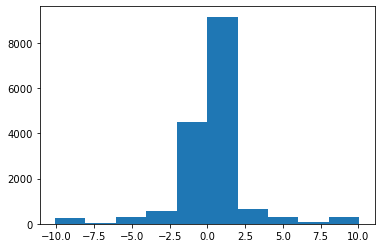

In [39]:
plt.hist( byvartbl_long_bs[ 'wmean_KTS_+_ratio_log2' ] )

In [115]:
byvartbl_long_bs[ 'sdv_KTS_+_ratio_log2' ] = ( np.abs( byvartbl_long_bs[ 'zwmean_bs_null_KTS_+_ratio_log2' ] ) >= ss.norm.ppf( 1 - bonfer ) ) \
                                 & ( np.abs( byvartbl_long_bs[ 'wmean_KTS_+_ratio_log2' ] ) >= 1 )

In [116]:
byvartbl_long_bs[ 'sdv' ] = byvartbl_long_bs[ [ col for col in byvartbl_long_bs if 'sdv_' in col ] ].any( axis = 1 )

In [117]:
byvartbl_long_bs[ 'intmed_SKIP' ] = ( byvartbl_long_bs[ 'zwmean_bs_null_SKIP' ] >= ss.norm.ppf( 1 - bonfer ) ) \
                                 & ( byvartbl_long_bs[ 'wmean_diff_SKIP' ] >= .1 )

In [118]:
byvartbl_long_bs[ 'intmed_OTHER' ] = ( byvartbl_long_bs[ 'zwmean_bs_null_OTHER' ] >= ss.norm.ppf( 1 - bonfer ) ) \
                                 & ( byvartbl_long_bs[ 'wmean_diff_OTHER' ] >= .1 )

In [44]:
byvartbl_long_bs[ 'intmed_KTS_+_ratio_log2' ] = ( np.abs( byvartbl_long_bs[ 'zwmean_bs_null_KTS_+_ratio_log2' ] ) >= ss.norm.ppf( 1 - bonfer ) ) \
                                 & ( np.abs( byvartbl_long_bs[ 'wmean_KTS_+_ratio_log2' ] ) >= 1.5 )

In [119]:
byvartbl_long_bs[ 'intmed' ] = byvartbl_long_bs[ [ col for col in byvartbl_long_bs if 'intmed_' in col ] ].any( axis = 1 )

In [120]:
byvartbl_wide_bs = mbcs.combine_rep_pervartbls_wide( [ byvartbl_long_bs.loc[ byvartbl_long_bs[ 'sample' ] == samp ][ [ col for col in byvartbl_long_bs if col != 'sample' and col != 'rep' ] ]
                                                    for samp in byvartbl_long_bs[ 'sample' ].unique() ],
                                                  [ samp for samp in byvartbl_long_bs[ 'sample' ].unique() ],
                                                  indexcols=[ 'chrom','pos','ref','ref_c','alt','alt_c','varlist','hg19_pos','hgvs_pos','exon_num' ], 
                                                  group_cols_by_samp = True )

In [121]:
byvartbl_wide = pd.read_table( data_in + 'wt1_ex9_by_var_effects_snvs_wide-2022-0621.txt' ) 

/home/smithcat/miniconda3/envs/splai3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3170: DtypeWarning: Columns (1203,1204,1205,1206,1207,1208) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [122]:
byvartbl_wide

,hgvs_pos,hg19_pos,ref,alt,ref_c,alt_c,pos,chrom,varlist,exon_num,...,splai_KTS+_ratio_log10,maxent_KTS+_nomiss,maxent_KTS-_nomiss,source,Interpretation_ACMG,human disease,other evidence,Reference,Comment,lit_var
0,c.1355-40,32413650,G,A,C,T,1227,11,jkp815:1227:C:T,9,...,NaN,6.678108,8.594409,NaN,NaN,NaN,NaN,NaN,NaN,False
1,c.1355-40,32413650,G,C,C,G,1227,11,jkp815:1227:C:G,9,...,NaN,6.678108,8.594409,NaN,NaN,NaN,NaN,NaN,NaN,False
2,c.1355-40,32413650,G,T,C,A,1227,11,jkp815:1227:C:A,9,...,NaN,6.678108,8.594409,NaN,NaN,NaN,NaN,NaN,NaN,False
3,c.1355-39,32413649,T,A,A,T,1228,11,jkp815:1228:A:T,9,...,NaN,6.678108,8.594409,NaN,NaN,NaN,NaN,NaN,NaN,False
4,c.1355-39,32413649,T,C,A,G,1228,11,jkp815:1228:A:G,9,...,NaN,6.678108,8.594409,NaN,NaN,NaN,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
513,c.1447+39,32413479,A,G,T,C,1398,11,jkp815:1398:T:C,9,...,-0.064919,6.678108,8.594409,NaN,NaN,NaN,NaN,NaN,NaN,False
514,c.1447+39,32413479,A,T,T,A,1398,11,jkp815:1398:T:A,9,...,-0.071990,6.678108,8.594409,NaN,NaN,NaN,NaN,NaN,NaN,False
515,c.1447+40,32413478,A,C,T,G,1399,11,jkp815:1399:T:G,9,...,-0.066454,6.678108,8.594409,NaN,NaN,NaN,NaN,NaN,NaN,False
516,c.1447+40,32413478,A,G,T,C,1399,11,jkp815:1399:T:C,9,...,-0.066585,6.678108,8.594409,NaN,NaN,NaN,NaN,NaN,NaN,False


In [123]:
new_cols = list( byvartbl_wide_bs.columns.difference( byvartbl_wide.columns ) )

In [124]:
merge_idx = [ 'pos', 'ref', 'alt' ]

byvartbl_wide_m = byvartbl_wide.set_index( merge_idx ).merge( byvartbl_wide_bs.set_index( merge_idx )[ new_cols ],
                                                              how = 'outer',
                                                              left_index = True,
                                                              right_index = True ).reset_index()

In [125]:
byvartbl_wide_m

,pos,ref,alt,hgvs_pos,hg19_pos,ref_c,alt_c,chrom,varlist,exon_num,...,BB_test_Cos1053_oligodT_MM2B_wmean_bs_null_SKIP,BB_test_Cos1053_oligodT_MM2B_wmean_diff_KTS_+_ratio_log2,BB_test_Cos1053_oligodT_MM2B_wmean_diff_OTHER,BB_test_Cos1053_oligodT_MM2B_wmean_diff_SKIP,BB_test_Cos1053_oligodT_MM2B_wstdev_bs_null_KTS_+_ratio_log2,BB_test_Cos1053_oligodT_MM2B_wstdev_bs_null_OTHER,BB_test_Cos1053_oligodT_MM2B_wstdev_bs_null_SKIP,BB_test_Cos1053_oligodT_MM2B_zwmean_bs_null_KTS_+_ratio_log2,BB_test_Cos1053_oligodT_MM2B_zwmean_bs_null_OTHER,BB_test_Cos1053_oligodT_MM2B_zwmean_bs_null_SKIP
0,1227,G,A,c.1355-40,32413650,C,T,11,jkp815:1227:C:T,9,...,0.085686,-0.255666,-0.001416,0.022758,0.464633,0.003976,0.039428,-0.550253,-0.356215,0.577210
1,1227,G,C,c.1355-40,32413650,C,G,11,jkp815:1227:C:G,9,...,0.085400,0.097881,0.014989,-0.028557,0.519060,0.004578,0.043111,0.188573,3.273824,-0.662421
2,1227,G,T,c.1355-40,32413650,C,A,11,jkp815:1227:C:A,9,...,0.085832,0.048771,-0.001641,0.001528,0.462060,0.004090,0.039987,0.105551,-0.401204,0.038214
3,1228,T,A,c.1355-39,32413649,A,T,11,jkp815:1228:A:T,9,...,0.085400,0.200157,-0.000951,0.003876,0.519060,0.004578,0.043111,0.385615,-0.207735,0.089915
4,1228,T,C,c.1355-39,32413649,A,G,11,jkp815:1228:A:G,9,...,0.084889,0.275115,-0.001303,-0.051383,0.692296,0.006134,0.055346,0.397395,-0.212390,-0.928396
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
513,1398,A,G,c.1447+39,32413479,T,C,11,jkp815:1398:T:C,9,...,0.072351,-1.247607,0.000550,-0.036286,1.987664,0.019729,0.111906,-0.627675,0.027900,-0.324250
514,1398,A,T,c.1447+39,32413479,T,A,11,jkp815:1398:T:A,9,...,0.072351,-0.018202,0.010049,-0.039586,1.987664,0.019729,0.111906,-0.009157,0.509364,-0.353741
515,1399,A,C,c.1447+40,32413478,T,G,11,jkp815:1399:T:G,9,...,0.076545,-0.433737,-0.000569,-0.044174,1.612335,0.013864,0.100510,-0.269012,-0.041042,-0.439498
516,1399,A,G,c.1447+40,32413478,T,C,11,jkp815:1399:T:C,9,...,0.064661,-4.393920,-0.002960,-0.009489,4.053943,0.004631,0.167125,-1.083863,-0.639149,-0.056778


In [126]:
for iso in iso_names:
    
    byvartbl_wide_m[ 'fc_' + iso ] = byvartbl_wide_m[ [ col for col in byvartbl_wide_m.columns if '_fc_' + iso in col ] ].median( axis = 1 )

In [127]:
for iso in iso_names:
    
    byvartbl_wide_m[ 'wmean_bs_null_' + iso ] = byvartbl_wide_m[ [ col for col in byvartbl_wide_m.columns if '_wmean_bs_null_' + iso in col ] ].median( axis = 1 )

In [128]:
for iso in iso_names:
    
    byvartbl_wide_m[ 'wmean_diff_' + iso ] = byvartbl_wide_m[ [ col for col in byvartbl_wide_m.columns if '_wmean_diff_' + iso in col ] ].median( axis = 1 )

In [129]:
for iso in iso_names:
    
    byvartbl_wide_m[ 'wmean_' + iso ] = byvartbl_wide_m[ [ col for col in byvartbl_wide_m.columns if '_wmean_' + iso in col ] ].median( axis = 1 )

In [130]:
byvartbl_wide_m = pp.stouffers_z( byvartbl_wide_m,
                                  iso_names,
                                  zcol = 'zwmean_bs_null_')

In [131]:
byvartbl_wide_m

,pos,ref,alt,hgvs_pos,hg19_pos,ref_c,alt_c,chrom,varlist,exon_num,...,wmean_bs_null_KTS_+_ratio_log2,wmean_bs_null_SKIP,wmean_bs_null_OTHER,wmean_diff_KTS_+_ratio_log2,wmean_diff_SKIP,wmean_diff_OTHER,wmean_KTS_+_ratio_log2,zwmean_bs_null_KTS_+_ratio_log2,zwmean_bs_null_SKIP,zwmean_bs_null_OTHER
0,1227,G,A,c.1355-40,32413650,C,T,11,jkp815:1227:C:T,9,...,0.247836,0.129163,0.002187,-0.016130,0.021825,-0.000460,0.168592,-1.267180,4.973602,-1.873450
1,1227,G,C,c.1355-40,32413650,C,G,11,jkp815:1227:C:G,9,...,0.248120,0.129227,0.002175,-0.060905,-0.025325,-0.000080,0.214672,-0.959788,-6.413922,-0.036895
2,1227,G,T,c.1355-40,32413650,C,A,11,jkp815:1227:C:A,9,...,0.246221,0.129343,0.002211,-0.039144,-0.058895,-0.000093,0.189133,-0.973156,-9.102060,0.378136
3,1228,T,A,c.1355-39,32413649,A,T,11,jkp815:1228:A:T,9,...,0.248596,0.129308,0.002175,-0.023847,0.035320,-0.000400,0.245710,-1.040104,7.388977,-1.869384
4,1228,T,C,c.1355-39,32413649,A,G,11,jkp815:1228:A:G,9,...,0.247581,0.129197,0.002226,-0.046009,-0.037479,-0.000031,0.190774,-0.340768,-5.528064,1.955259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
513,1398,A,G,c.1447+39,32413479,T,C,11,jkp815:1398:T:C,9,...,0.251607,0.124034,0.002149,-0.200475,-0.039466,-0.001396,0.050082,-1.409693,-2.544955,-1.196672
514,1398,A,T,c.1447+39,32413479,T,A,11,jkp815:1398:T:A,9,...,0.257935,0.125284,0.002136,-0.196206,-0.040116,-0.001609,0.074802,-1.469582,-2.217009,-1.087807
515,1399,A,C,c.1447+40,32413478,T,G,11,jkp815:1399:T:G,9,...,0.255797,0.125359,0.002332,0.073984,-0.036799,-0.001584,0.340589,1.018451,-1.977212,-1.155702
516,1399,A,G,c.1447+40,32413478,T,C,11,jkp815:1399:T:C,9,...,0.258963,0.120151,0.002505,-0.215171,-0.023888,-0.001715,0.017504,-1.230098,0.471389,-0.536184


KTS_+_ratio_log2


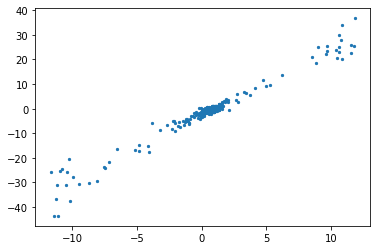

SKIP


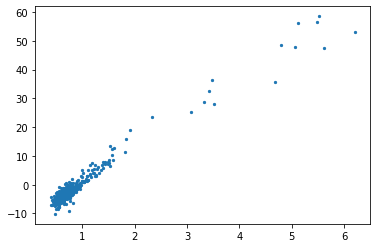

OTHER


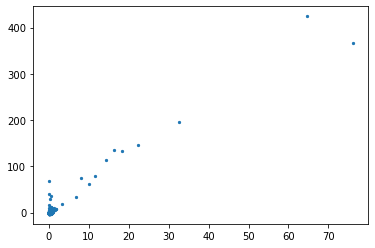

In [132]:
for iso in iso_names:
    
    print( iso )
    
    plt.scatter( byvartbl_wide_m[ 'fc_' + iso ],
                 byvartbl_wide_m[ 'zwmean_bs_null_' + iso ],
                 s = 5 )
    
    plt.ylim(  )
    
    plt.show()

In [133]:
byvartbl_wide_m.loc[ byvartbl_wide_m[ 'Interpretation_ACMG' ].isnull(), 'Interpretation_ACMG' ] = ''

In [134]:
byvartbl_wide_m[ 'Interpretation_ACMG' ].unique()

array(['', 'Likely benign', 'VUS', 'Pathogenic', 'Benign'], dtype=object)

In [135]:
byvartbl_wide_m[ 'lit_var_interp_num' ] = [ 10 if i == '' else( 20 if i == 'Benign' else ( 30 if i == 'Likely benign' else( 40 if i == 'VUS' else 50 ) ) ) for i in byvartbl_wide_m[ 'Interpretation_ACMG' ] ]

In [136]:
byvartbl_wide_m[ 'lit_var_path' ] = ( byvartbl_wide_m[ 'Interpretation_ACMG' ] == 'Pathogenic' ) 

In [137]:
byvartbl_wide_m[ 'lit_var_lbb' ] = ( byvartbl_wide_m[ 'Interpretation_ACMG' ] == 'Benign' ) | ( byvartbl_wide_m[ 'Interpretation_ACMG' ] == 'Likely benign' )

KTS_+_ratio_log2


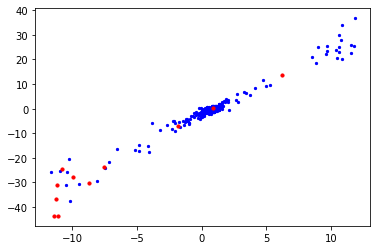

SKIP


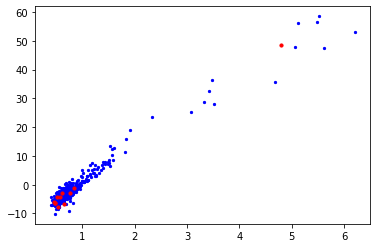

OTHER


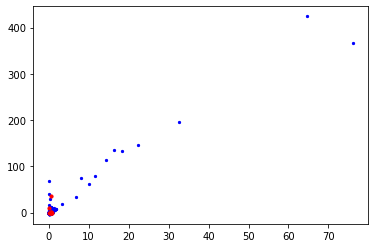

In [138]:
for iso in iso_names:
    
    print( iso )
    
    plt.scatter( byvartbl_wide_m.loc[ ~byvartbl_wide_m.lit_var_path ][ 'fc_' + iso ],
                 byvartbl_wide_m.loc[ ~byvartbl_wide_m.lit_var_path ][ 'zwmean_bs_null_' + iso ],
                 c = 'blue',
                 s = 5 )
    
    plt.scatter( byvartbl_wide_m.loc[ byvartbl_wide_m.lit_var_path ][ 'fc_' + iso ],
                 byvartbl_wide_m.loc[ byvartbl_wide_m.lit_var_path ][ 'zwmean_bs_null_' + iso ],
                 c = 'red',
                 s = 10 )
    
    plt.show()

KTS_+_ratio_log2


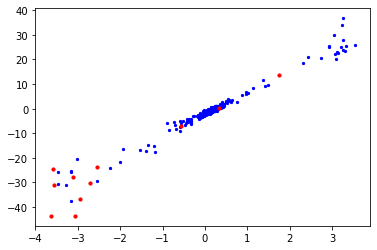

SKIP


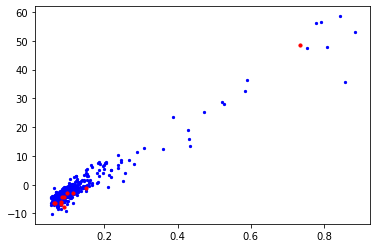

OTHER


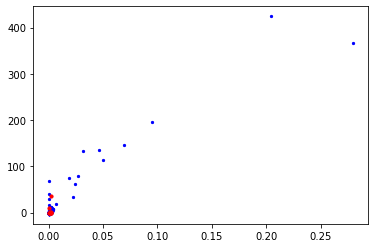

In [139]:
for iso in iso_names:
    
    print( iso )
    
    plt.scatter( byvartbl_wide_m.loc[ ~byvartbl_wide_m.lit_var_path ][ 'wmean_' + iso ],
                 byvartbl_wide_m.loc[ ~byvartbl_wide_m.lit_var_path ][ 'zwmean_bs_null_' + iso ],
                 c = 'blue',
                 s = 5 )
    
    plt.scatter( byvartbl_wide_m.loc[ byvartbl_wide_m.lit_var_path ][ 'wmean_' + iso ],
                 byvartbl_wide_m.loc[ byvartbl_wide_m.lit_var_path ][ 'zwmean_bs_null_' + iso ],
                 c = 'red',
                 s = 10 )
    
    plt.show()

In [140]:
byvartbl_wide_m[ 'sdv_SKIP' ] = ( byvartbl_wide_m[ 'zwmean_bs_null_SKIP' ] >= ss.norm.ppf( 1 - bonfer ) ) \
                                 & ( byvartbl_wide_m[ 'wmean_diff_SKIP' ] >= .2 )

In [141]:
byvartbl_wide_m[ 'sdv_OTHER' ] = ( byvartbl_wide_m[ 'zwmean_bs_null_OTHER' ] >= ss.norm.ppf( 1 - bonfer ) ) \
                                 & ( byvartbl_wide_m[ 'wmean_diff_OTHER' ] >= .2 )

In [143]:
byvartbl_wide_m[ 'sdv_KTS_+_ratio_log2' ] = ( np.abs( byvartbl_wide_m[ 'zwmean_bs_null_KTS_+_ratio_log2' ] ) >= ss.norm.ppf( 1 - bonfer ) ) \
                                 & ( np.abs( byvartbl_wide_m[ 'wmean_KTS_+_ratio_log2' ] ) >= 1 )

In [144]:
byvartbl_wide_m[ 'intmed_SKIP' ] = ( byvartbl_wide_m[ 'zwmean_bs_null_SKIP' ] >= ss.norm.ppf( 1 - bonfer ) ) \
                                 & ( byvartbl_wide_m[ 'wmean_diff_SKIP' ] >= .1 )

In [145]:
byvartbl_wide_m[ 'intmed_OTHER' ] = ( byvartbl_wide_m[ 'zwmean_bs_null_OTHER' ] >= ss.norm.ppf( 1 - bonfer ) ) \
                                 & ( byvartbl_wide_m[ 'wmean_diff_OTHER' ] >= .1 )

In [146]:
byvartbl_wide_m[ 'intmed_KTS_+_ratio_log2' ] = ( np.abs( byvartbl_wide_m[ 'zwmean_bs_null_KTS_+_ratio_log2' ] ) >= ss.norm.ppf( 1 - bonfer ) ) \
                                 & ( np.abs( byvartbl_wide_m[ 'wmean_KTS_+_ratio_log2' ] ) >= 1 )

In [71]:
#this gave me wayyyyy to many OTHER
#for iso in iso_names:
    
    #byvartbl_wide_m[ 'sdv_' + iso ] = byvartbl_wide_m[ [ col for col in byvartbl_wide_m if '_sdv_' + iso in col ] ].any( axis = 1 )

In [72]:
#byvartbl_wide_m = pp.sdv_by_iso( byvartbl_wide_m,
                                   #iso_names,
                                   #'zwmean_bs_null_',
                                   #ss.norm.ppf( 1 - bonfer ),
                                   #'fc_',
                                   #2,
                                   #out_col_stem = 'sdv_fc2+_',
                                   #bi_directional = False
                                   #)

In [73]:
byvartbl_wide_m

,pos,ref,alt,hgvs_pos,hg19_pos,ref_c,alt_c,chrom,varlist,exon_num,...,zwmean_bs_null_OTHER,lit_var_interp_num,lit_var_path,lit_var_lbb,sdv_SKIP,sdv_OTHER,sdv_KTS_+_ratio_log2,intmed_SKIP,intmed_OTHER,intmed_KTS_+_ratio_log2
0,1227,G,A,c.1355-40,32413650,C,T,11,jkp815:1227:C:T,9,...,-1.873450,10,False,False,False,False,False,False,False,False
1,1227,G,C,c.1355-40,32413650,C,G,11,jkp815:1227:C:G,9,...,-0.036895,10,False,False,False,False,False,False,False,False
2,1227,G,T,c.1355-40,32413650,C,A,11,jkp815:1227:C:A,9,...,0.378136,10,False,False,False,False,False,False,False,False
3,1228,T,A,c.1355-39,32413649,A,T,11,jkp815:1228:A:T,9,...,-1.869384,10,False,False,False,False,False,False,False,False
4,1228,T,C,c.1355-39,32413649,A,G,11,jkp815:1228:A:G,9,...,1.955259,10,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
513,1398,A,G,c.1447+39,32413479,T,C,11,jkp815:1398:T:C,9,...,-1.196672,10,False,False,False,False,False,False,False,False
514,1398,A,T,c.1447+39,32413479,T,A,11,jkp815:1398:T:A,9,...,-1.087807,10,False,False,False,False,False,False,False,False
515,1399,A,C,c.1447+40,32413478,T,G,11,jkp815:1399:T:G,9,...,-1.155702,10,False,False,False,False,False,False,False,False
516,1399,A,G,c.1447+40,32413478,T,C,11,jkp815:1399:T:C,9,...,-0.536184,10,False,False,False,False,False,False,False,False


In [147]:
byvartbl_wide_m[ 'sdv' ] = byvartbl_wide_m[ [ 'sdv_' + iso for iso in iso_names ] ].any( axis = 'columns' )

In [148]:
byvartbl_wide_m[ 'intmed' ] = ( byvartbl_wide_m[ [ 'intmed_' + iso for iso in iso_names ] ].any( axis = 'columns' ) ) & ~( byvartbl_wide_m.sdv )

In [149]:
byvartbl_wide_m[ 'sdv_exon' ] = ( byvartbl_wide_m.pos >= 1267 ) & ( byvartbl_wide_m.pos <= 1359 ) & ( byvartbl_wide_m[ 'sdv' ] )
byvartbl_wide_m[ 'sdv_intron' ] = ( ( byvartbl_wide_m.pos < 1267 ) | ( byvartbl_wide_m.pos > 1359 ) ) & ( byvartbl_wide_m[ 'sdv' ] )

In [150]:
byvartbl_wide_m[ 'intmed_exon' ] = ( byvartbl_wide_m.pos >= 1267 ) & ( byvartbl_wide_m.pos <= 1359 ) & ( byvartbl_wide_m[ 'intmed' ] )
byvartbl_wide_m[ 'intmed_intron' ] = ( ( byvartbl_wide_m.pos < 1267 ) | ( byvartbl_wide_m.pos > 1359 ) ) & ( byvartbl_wide_m[ 'intmed' ] )

In [151]:
byvartbl_wide_m[ 'exon' ] = ( byvartbl_wide_m.pos >= 1267 ) & ( byvartbl_wide_m.pos <= 1359 ) 
byvartbl_wide_m[ 'intron' ] = ( ( byvartbl_wide_m.pos < 1267 ) | ( byvartbl_wide_m.pos > 1359 ) )

In [152]:
byvartbl_wide_m.loc[ byvartbl_wide_m.intmed ]

,pos,ref,alt,hgvs_pos,hg19_pos,ref_c,alt_c,chrom,varlist,exon_num,...,intmed_OTHER,intmed_KTS_+_ratio_log2,sdv,intmed,sdv_exon,sdv_intron,intmed_exon,intmed_intron,exon,intron
24,1235,C,A,c.1355-32,32413642,G,T,11,jkp815:1235:G:T,9,...,False,False,False,True,False,False,False,True,False,True
63,1248,T,A,c.1355-19,32413629,A,T,11,jkp815:1248:A:T,9,...,False,False,False,True,False,False,False,True,False,True
81,1254,A,C,c.1355-13,32413623,T,G,11,jkp815:1254:T:G,9,...,False,False,False,True,False,False,False,True,False,True
84,1255,G,A,c.1355-12,32413622,C,T,11,jkp815:1255:C:T,9,...,False,False,False,True,False,False,False,True,False,True
90,1257,C,A,c.1355-10,32413620,G,T,11,jkp815:1257:G:T,9,...,False,False,False,True,False,False,False,True,False,True
94,1258,A,T,c.1355-9,32413619,T,A,11,jkp815:1258:T:A,9,...,False,False,False,True,False,False,False,True,False,True
101,1261,T,A,c.1355-6,32413616,A,T,11,jkp815:1261:A:T,9,...,False,False,False,True,False,False,False,True,False,True
161,1281,G,A,c.1369,32413596,C,T,11,jkp815:1281:C:T,9,...,False,False,False,True,False,False,True,False,True,False


In [80]:
github_colors = '3182bd6baed69ecae1c6dbefe6550dfd8d3cfdae6bfdd0a231a35474c476a1d99bc7e9c0756bb19e9ac8bcbddcdadaeb636363969696bdbdbdd9d9d9'

In [81]:
light_colors = [ '#' + github_colors[i:i+6] for i in range( 0, len( github_colors ), 6 ) ]

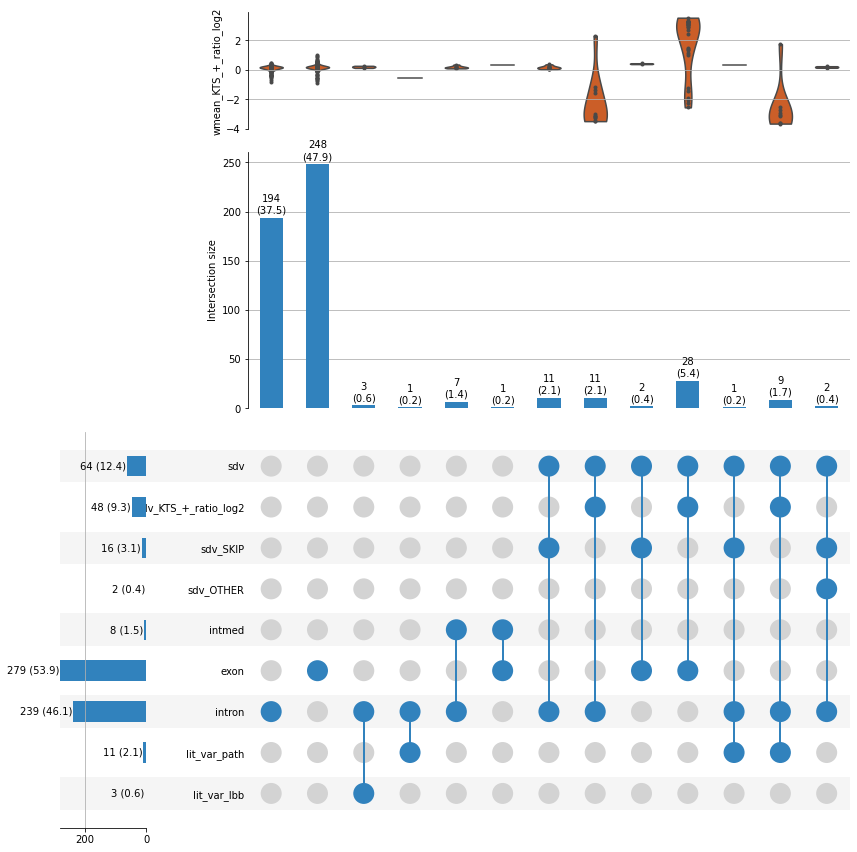

In [153]:
sp.upset_plot( byvartbl_wide_m, 
               [ 'sdv', 'sdv_KTS_+_ratio_log2', 'sdv_SKIP', 'sdv_OTHER', 'intmed', 'exon', 'intron', 'lit_var_path', 'lit_var_lbb' ][::-1],
                ( 14, 14 ),
                [ 'wmean_KTS_+_ratio_log2' ],
                [ 'violin' ],
                [ light_colors[ 4 ] ],
                show_counts = '%d',
                show_percentages = '%.1f',
                facecolor = light_colors[ 0 ],
                element_size = 60,
               sort_categories_by = None,
              )

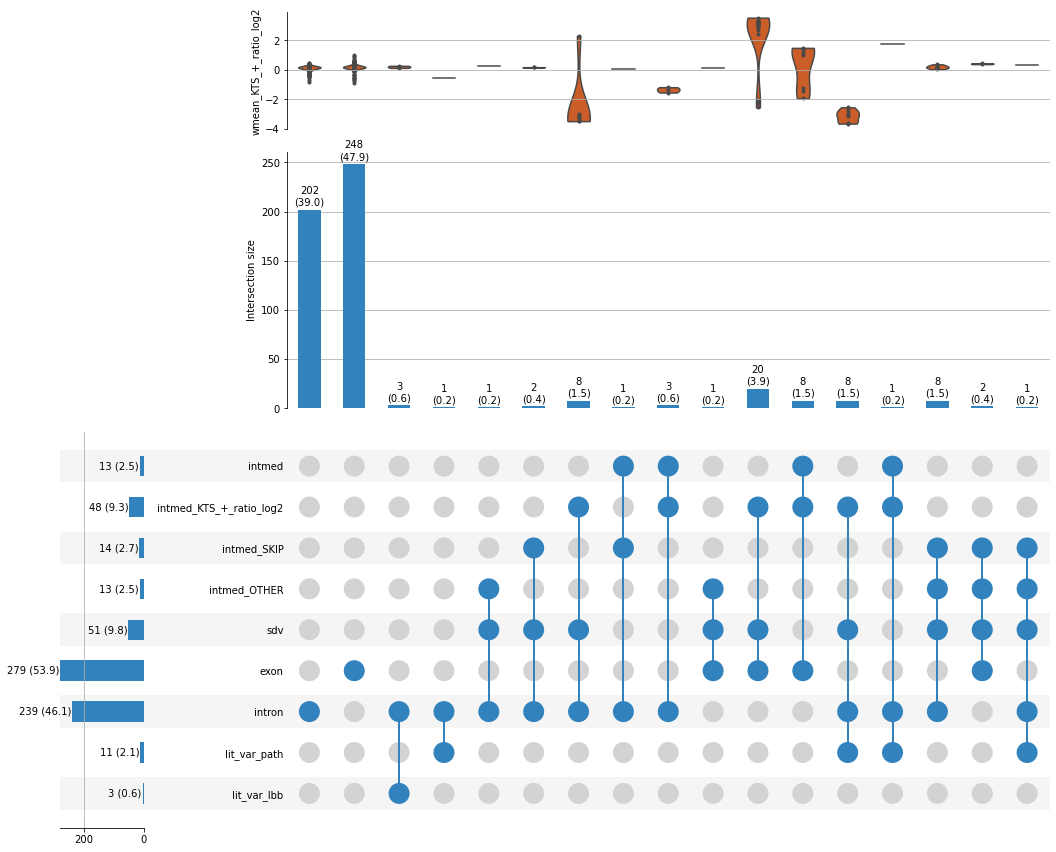

In [102]:
sp.upset_plot( byvartbl_wide_m, 
               [ 'intmed', 'intmed_KTS_+_ratio_log2', 'intmed_SKIP', 'intmed_OTHER', 'sdv', 'exon', 'intron', 'lit_var_path', 'lit_var_lbb' ][::-1],
                ( 14, 14 ),
                [ 'wmean_KTS_+_ratio_log2' ],
                [ 'violin' ],
                [ light_colors[ 4 ] ],
                show_counts = '%d',
                show_percentages = '%.1f',
                facecolor = light_colors[ 0 ],
                element_size = 60,
               sort_categories_by = None,
              )

In [154]:
byvartbl_sat = pp.saturate_variants( byvartbl_wide_m,
                                     chr11_seq,
                                     'hg19_pos',
                                      'exon_num',
                                      rev_strand = True )[ 9 ]

In [155]:
#plots get messed up without the vector position included
byvartbl_sat[ 'pos' ] = byvartbl_sat.hg19_pos - 32412079 - 2*( byvartbl_sat.hg19_pos - byvartbl_sat.hg19_pos.min() )

In [156]:
byvartbl_sat[ 'hgvs_pos' ] = cds.pos_to_hgvspos( byvartbl_sat.pos,
                                                 ( 1058, 1554 ),
                                                [ (1267, 1359) ],
                                                [ ( 1355, 1447 ), ]
                                                )

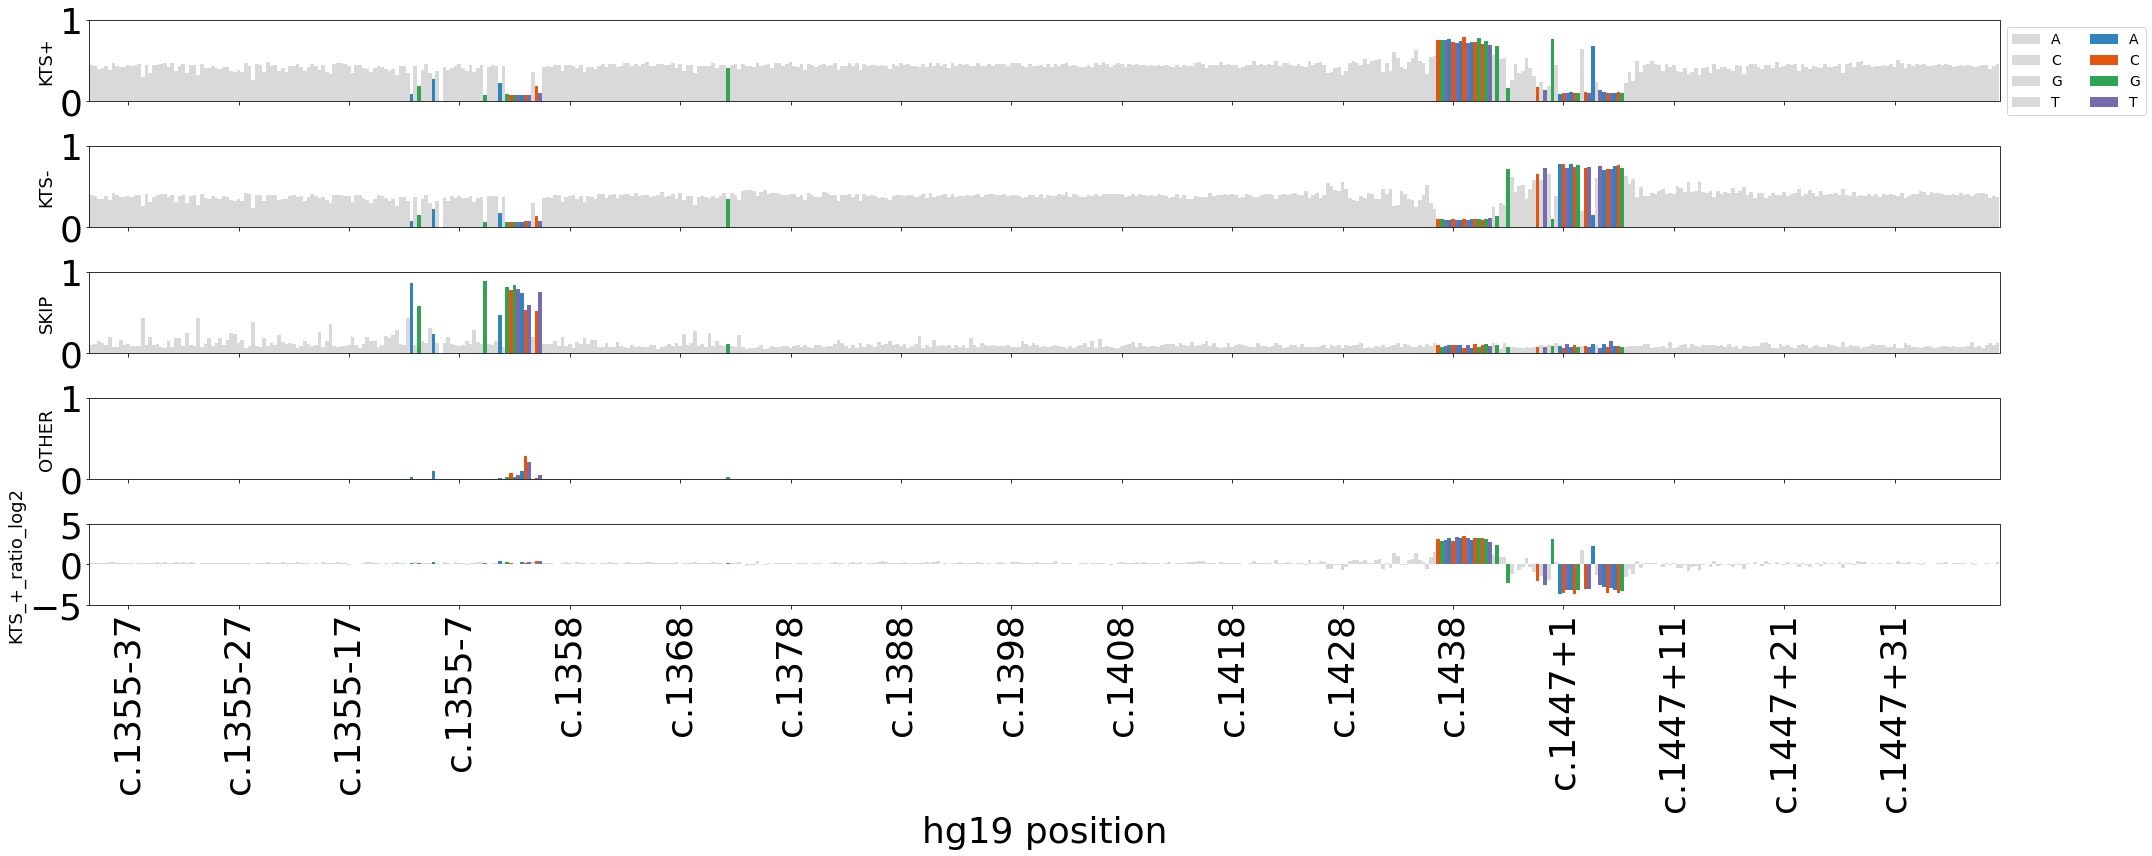

In [86]:
sp.sat_subplots_wrapper( byvartbl_sat.rename( columns = { 'alt': 'a',
                                                          'ref': 'r',
                                                           'alt_c': 'alt',
                                                           'ref_c': 'ref' } ),
                         [ col for col in byvartbl_sat if col.startswith( 'wmean_' ) and '_bs_' not in col ],
                         'hgvs_pos',
                          [ '.85', '.85', '.85', '.85' ],
                          fig_size = ( 30, 12 ),
                          share_y = False,
                          #legend = False,
                          #darken_bars = [ ( 'sdv', [ l for idx,l in enumerate( light_colors ) if idx%4 == 3 ] ) ],
                          darken_bars = [ ( 'sdv', [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ) ],
                          y_ax_lim = [ ( 0, 1 ), ( 0, 1 ), ( 0, 1 ), ( 0, 1 ), ( -5, 5 ) ],
                          y_ax_title = [ col[ 6: ] for col in byvartbl_sat if col.startswith( 'wmean_' ) and '_bs_' not in col ], 
                          x_ax_title = 'hg19 position',
                          tick_spacing = 10,
                          #savefile = '/nfs/kitzman2/smithcat/proj/spliceAI/plots/fas_tracks.pdf'
                     )

In [158]:
[ col for col in byvartbl_sat if col.startswith( 'wmean_' ) and '_bs_' not in col ]

['wmean_KTS+',
 'wmean_KTS-',
 'wmean_SKIP',
 'wmean_OTHER',
 'wmean_diff_KTS_+_ratio_log2',
 'wmean_diff_SKIP',
 'wmean_diff_OTHER',
 'wmean_KTS_+_ratio_log2']

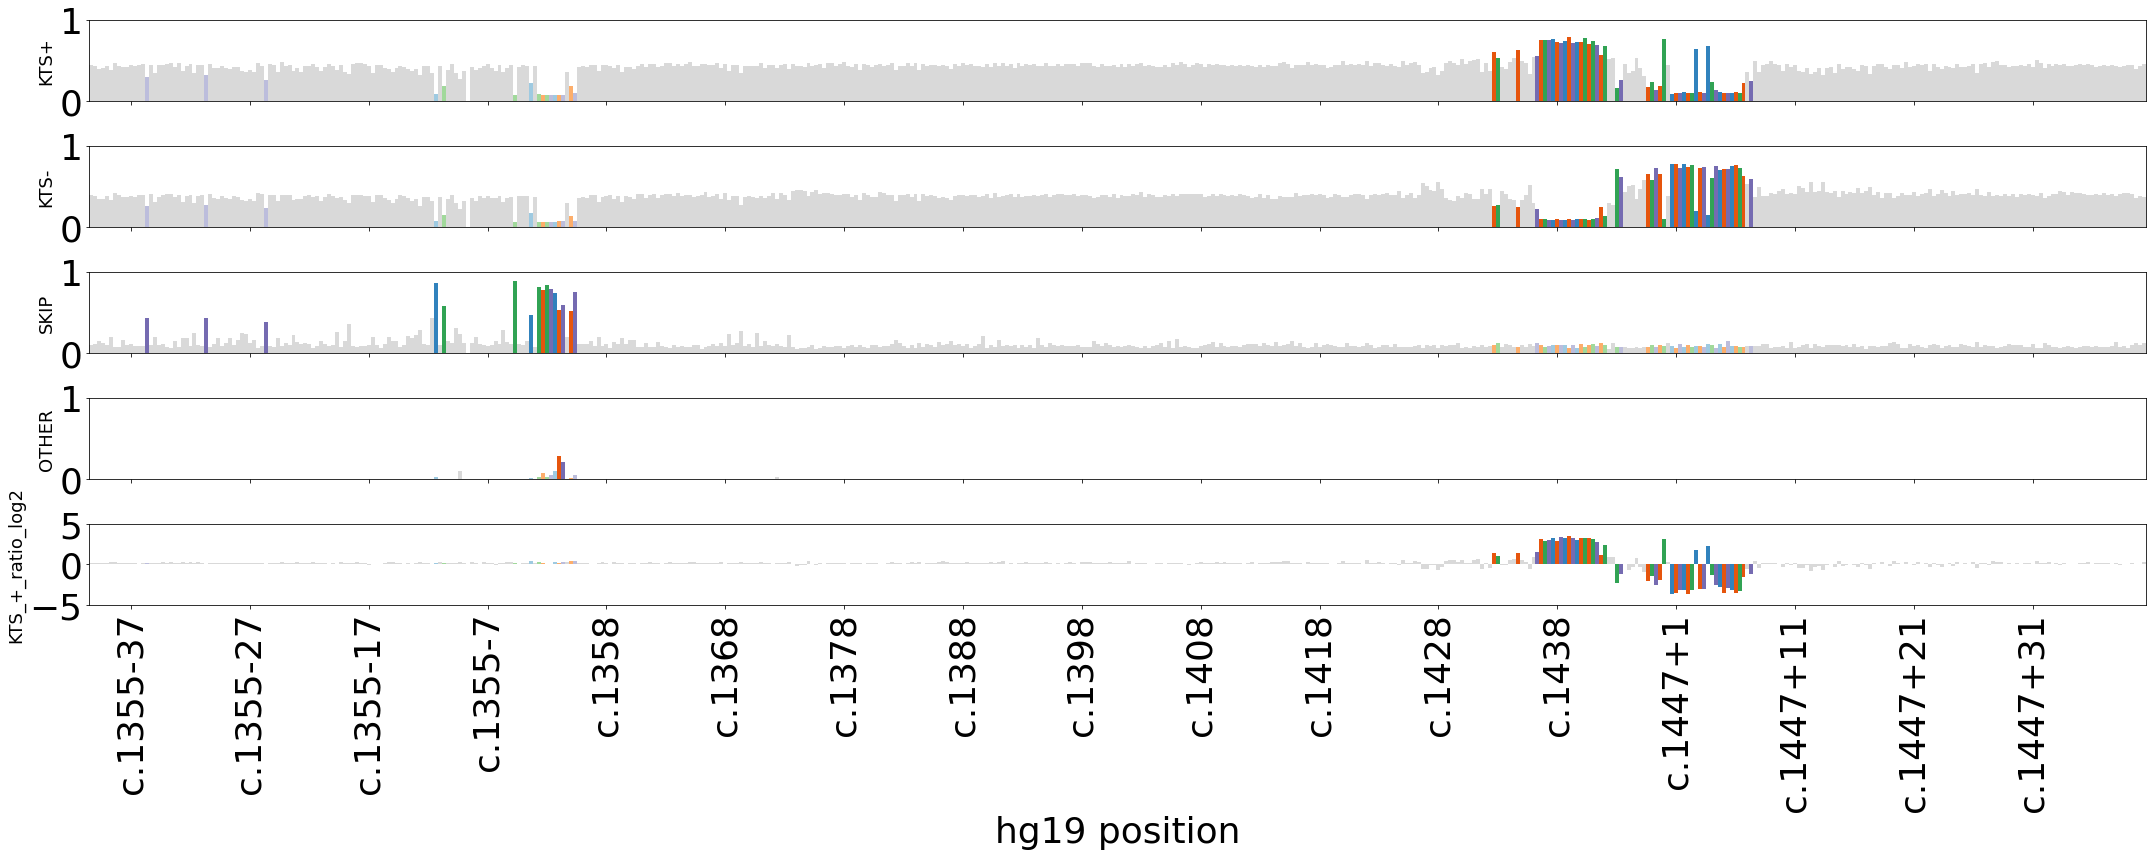

In [159]:
sp.sat_subplots_wrapper( byvartbl_sat.rename( columns = { 'alt': 'a',
                                                          'ref': 'r',
                                                           'alt_c': 'alt',
                                                           'ref_c': 'ref' } ),
                         [ col for col in byvartbl_sat if col.startswith( 'wmean_' ) and '_bs_' not in col and 'diff' not in col ],
                         'hgvs_pos',
                          [ '.85', '.85', '.85', '.85' ],
                          fig_size = ( 30, 12 ),
                          share_y = False,
                          legend = False,
                          darken_bars = [ ( 'sdv', [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ) ],
                          darken_bars2 = [ ( 'sdv_KTS_+_ratio_log2', [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv_KTS_+_ratio_log2', [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv_SKIP' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv_OTHER' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv_KTS_+_ratio_log2' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ) ],
                          y_ax_lim = [ ( 0, 1 ), ( 0, 1 ), ( 0, 1 ), ( 0, 1 ), ( -5, 5 ) ],
                          y_ax_title = [ col[ 6: ] for col in byvartbl_sat if col.startswith( 'wmean_' ) and '_bs_' not in col and 'diff' not in col ], 
                          x_ax_title = 'hg19 position',
                          tick_spacing = 10,
                          #savefile = '/nfs/kitzman2/smithcat/proj/spliceAI/plots/fas_tracks.pdf'
                     )

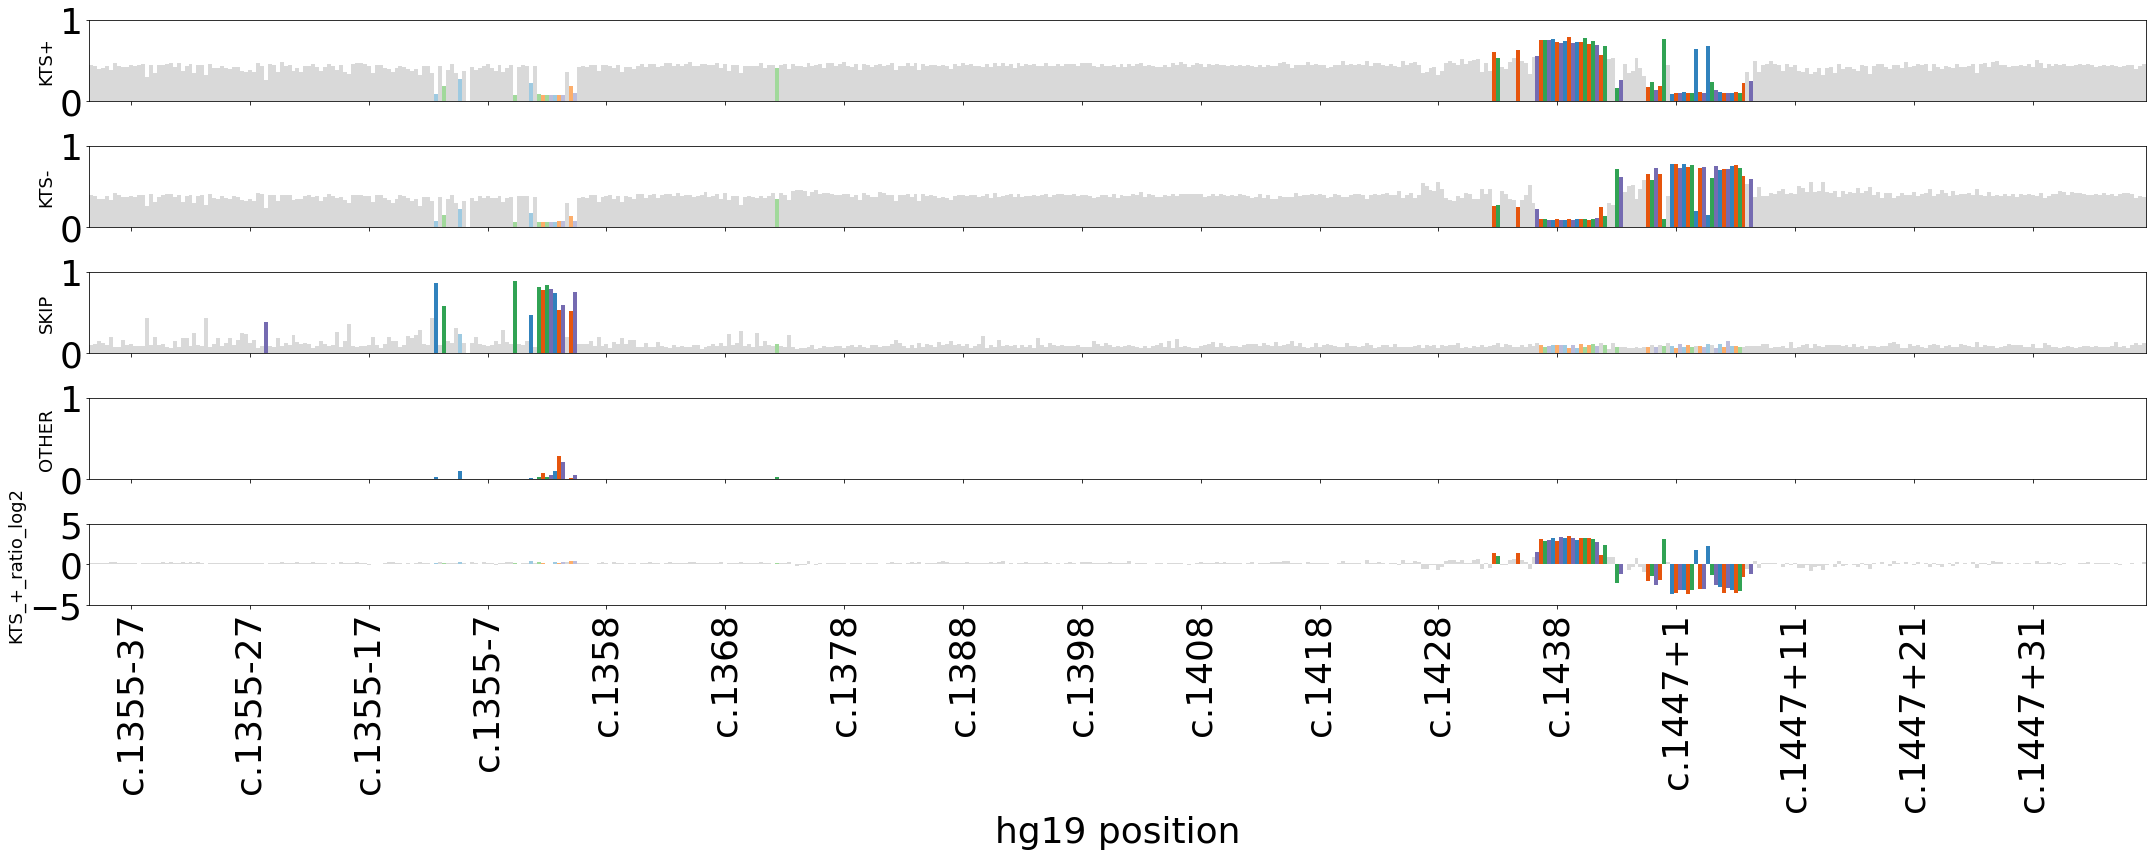

In [88]:
sp.sat_subplots_wrapper( byvartbl_sat.rename( columns = { 'alt': 'a',
                                                          'ref': 'r',
                                                           'alt_c': 'alt',
                                                           'ref_c': 'ref' } ),
                         [ col for col in byvartbl_sat if col.startswith( 'wmean_' ) and '_bs_' not in col ],
                         'hgvs_pos',
                          [ '.85', '.85', '.85', '.85' ],
                          fig_size = ( 30, 12 ),
                          share_y = False,
                          legend = False,
                          darken_bars = [ ( 'sdv', [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ) ],
                          darken_bars2 = [ ( 'intmed_KTS_+_ratio_log2', [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'intmed_KTS_+_ratio_log2', [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'intmed_SKIP' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'intmed_OTHER' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'intmed_KTS_+_ratio_log2' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ) ],
                          y_ax_lim = [ ( 0, 1 ), ( 0, 1 ), ( 0, 1 ), ( 0, 1 ), ( -5, 5 ) ],
                          y_ax_title = [ col[ 6: ] for col in byvartbl_sat if col.startswith( 'wmean_' ) and '_bs_' not in col ], 
                          x_ax_title = 'hg19 position',
                          tick_spacing = 10,
                          #savefile = '/nfs/kitzman2/smithcat/proj/spliceAI/plots/fas_tracks.pdf'
                     )

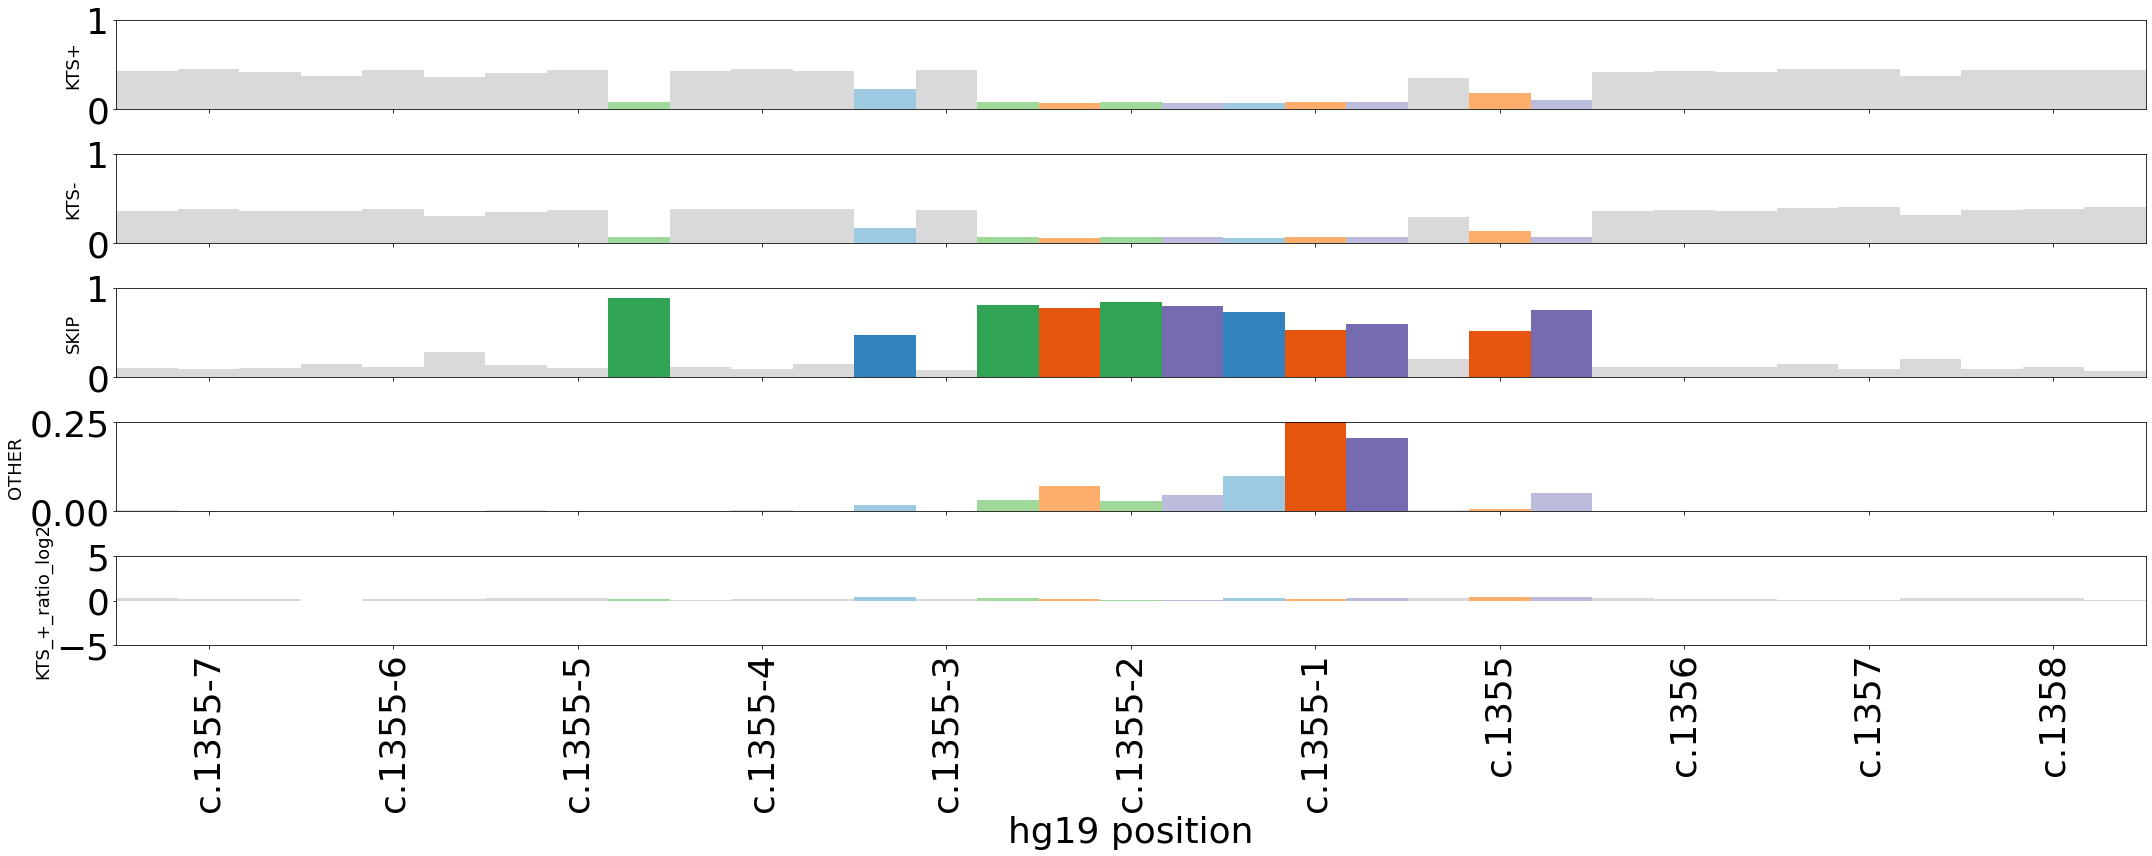

In [160]:
sp.sat_subplots_wrapper( byvartbl_sat.rename( columns = { 'alt': 'a',
                                                          'ref': 'r',
                                                           'alt_c': 'alt',
                                                           'ref_c': 'ref' } ),
                         [ col for col in byvartbl_sat if col.startswith( 'wmean_' ) and '_bs_' not in col and not 'diff'  in col  ],
                         'hgvs_pos',
                          [ '.85', '.85', '.85', '.85' ],
                          fig_size = ( 30, 12 ),
                          zoom = ( 1260, 1270 ),
                          share_y = False,
                          legend = False,
                          darken_bars = [ ( 'sdv', [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ) ],
                          darken_bars2 = [ ( 'sdv_KTS_+_ratio_log2', [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv_KTS_+_ratio_log2', [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv_SKIP' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv_OTHER' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv_KTS_+_ratio_log2' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ) ],
                          y_ax_lim = [ ( 0, 1 ), ( 0, 1 ), ( 0, 1 ), ( 0, .25 ), ( -5, 5 ) ],
                          y_ax_title = [ col[ 6: ] for col in byvartbl_sat if col.startswith( 'wmean_' ) and '_bs_' not in col and not 'diff' in col  ], 
                          x_ax_title = 'hg19 position',
                          tick_spacing = 1,
                          #savefile = '/nfs/kitzman2/smithcat/proj/spliceAI/plots/fas_tracks.pdf'
                     )

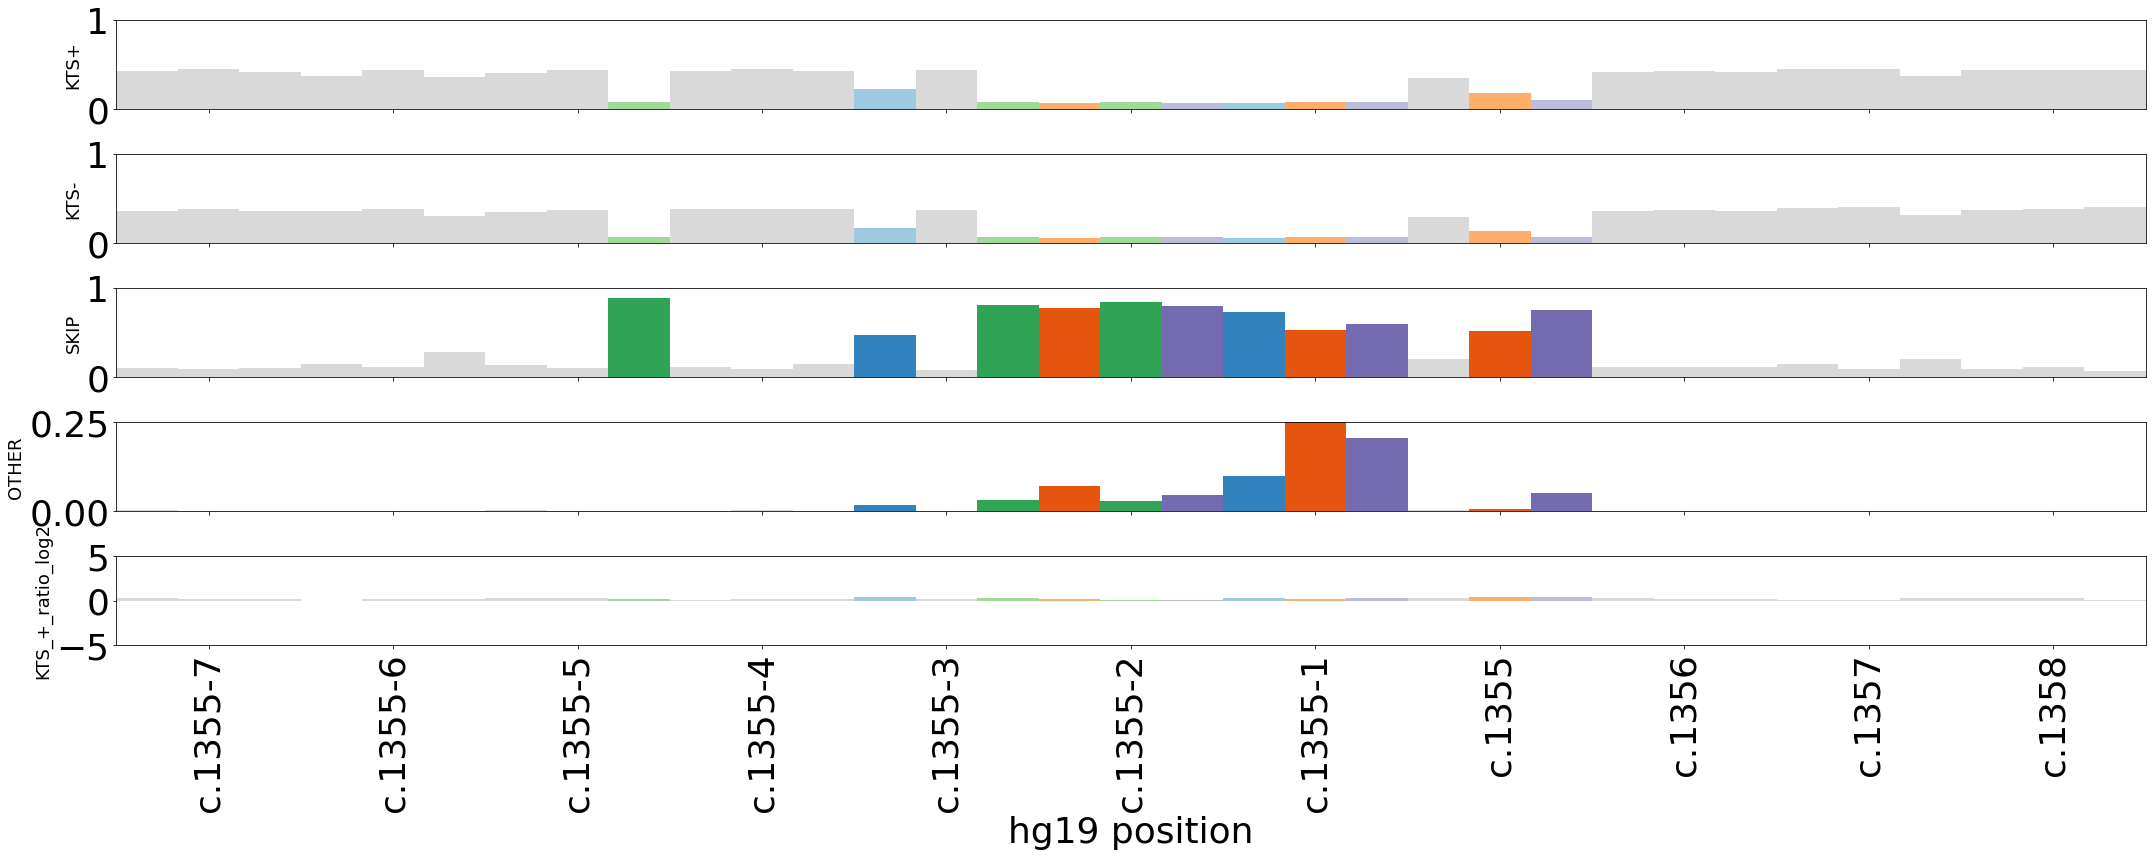

In [90]:
sp.sat_subplots_wrapper( byvartbl_sat.rename( columns = { 'alt': 'a',
                                                          'ref': 'r',
                                                           'alt_c': 'alt',
                                                           'ref_c': 'ref' } ),
                         [ col for col in byvartbl_sat if col.startswith( 'wmean_' ) and '_bs_' not in col ],
                         'hgvs_pos',
                          [ '.85', '.85', '.85', '.85' ],
                          fig_size = ( 30, 12 ),
                          zoom = ( 1260, 1270 ),
                          share_y = False,
                          legend = False,
                          darken_bars = [ ( 'sdv', [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ) ],
                          darken_bars2 = [ ( 'intmed_KTS_+_ratio_log2', [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'intmed_KTS_+_ratio_log2', [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'intmed_SKIP' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'intmed_OTHER' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'intmed_KTS_+_ratio_log2' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ) ],
                          y_ax_lim = [ ( 0, 1 ), ( 0, 1 ), ( 0, 1 ), ( 0, .25 ), ( -5, 5 ) ],
                          y_ax_title = [ col[ 6: ] for col in byvartbl_sat if col.startswith( 'wmean_' ) and '_bs_' not in col ], 
                          x_ax_title = 'hg19 position',
                          tick_spacing = 1,
                          #savefile = '/nfs/kitzman2/smithcat/proj/spliceAI/plots/fas_tracks.pdf'
                     )

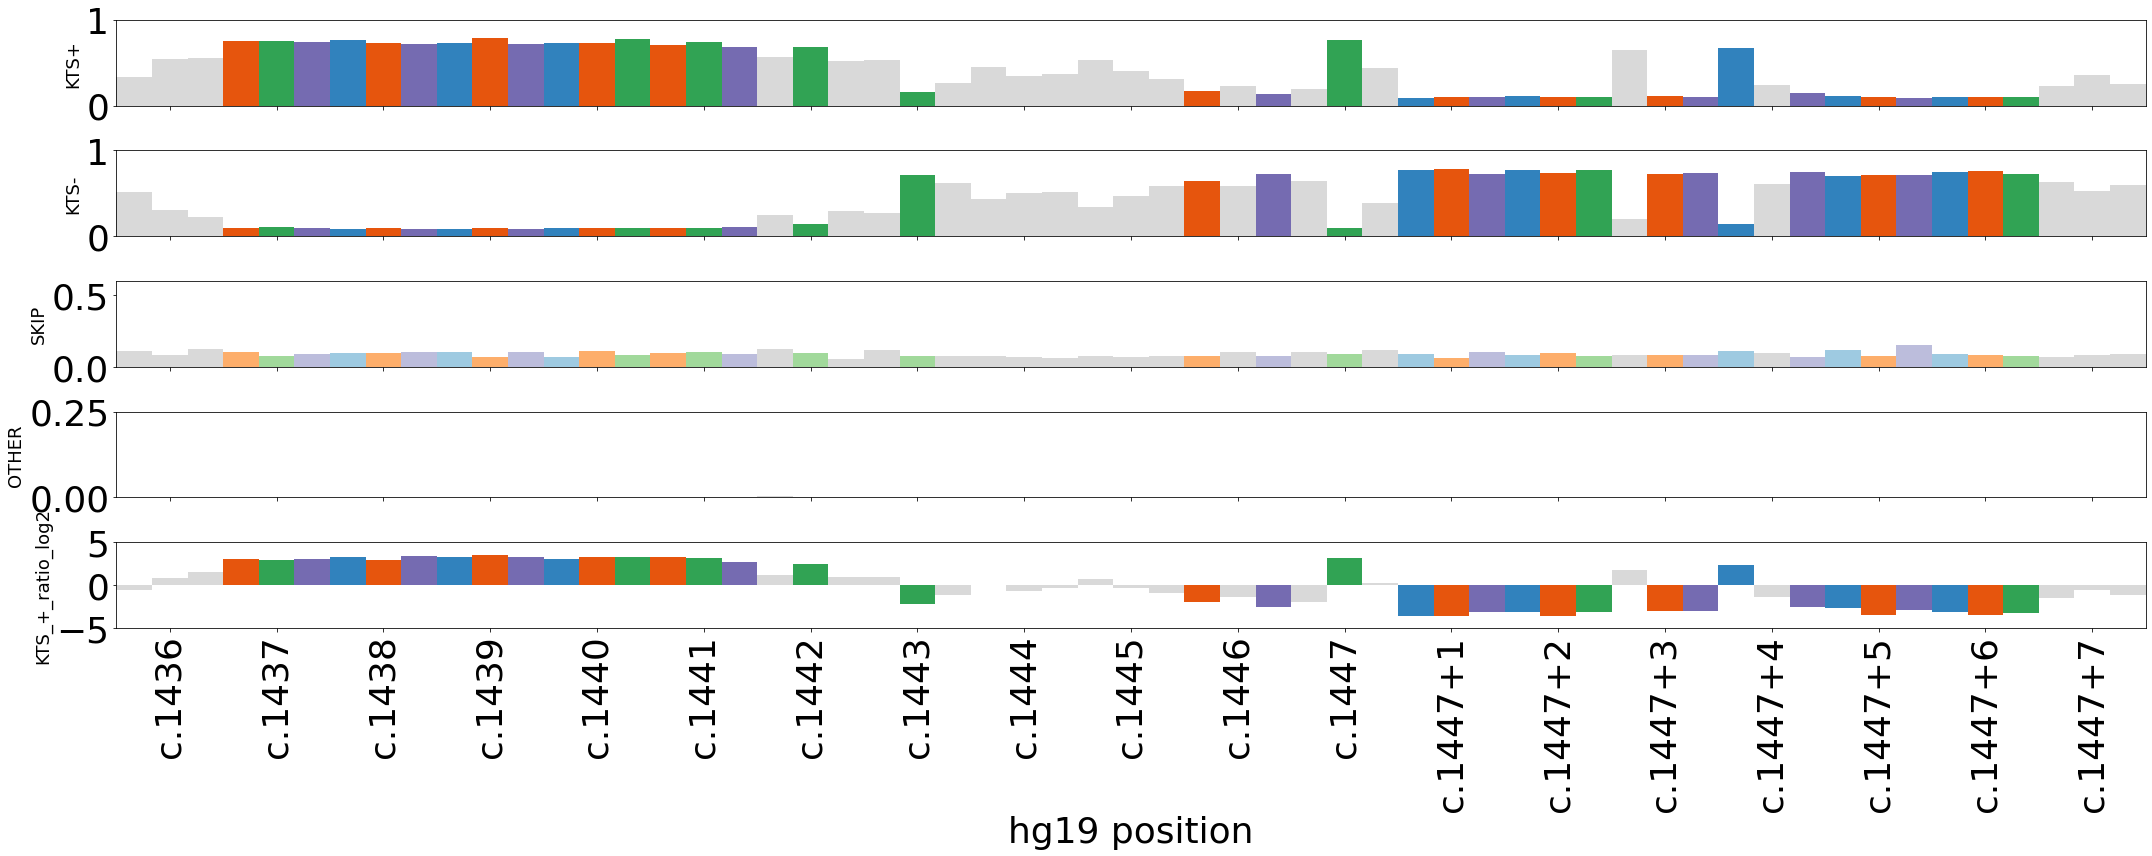

In [91]:
sp.sat_subplots_wrapper( byvartbl_sat.rename( columns = { 'alt': 'a',
                                                          'ref': 'r',
                                                           'alt_c': 'alt',
                                                           'ref_c': 'ref' } ),
                         [ col for col in byvartbl_sat if col.startswith( 'wmean_' ) and '_bs_' not in col ],
                         'hgvs_pos',
                          [ '.85', '.85', '.85', '.85' ],
                          fig_size = ( 30, 12 ),
                          zoom = ( 1348, 1366 ),
                          share_y = False,
                          legend = False,
                          darken_bars = [ ( 'sdv', [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ) ],
                          darken_bars2 = [ ( 'sdv_KTS_+_ratio_log2', [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv_KTS_+_ratio_log2', [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv_SKIP' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv_OTHER' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv_KTS_+_ratio_log2' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ) ],
                          y_ax_lim = [ ( 0, 1 ), ( 0, 1 ), ( 0, .6 ), ( 0, .25 ), ( -5, 5 ) ],
                          y_ax_title = [ col[ 6: ] for col in byvartbl_sat if col.startswith( 'wmean_' ) and '_bs_' not in col ], 
                          x_ax_title = 'hg19 position',
                          tick_spacing = 1,
                          #savefile = '/nfs/kitzman2/smithcat/proj/spliceAI/plots/fas_tracks.pdf'
                     )

In [103]:
byvartbl_wide_m.loc[ ( byvartbl_wide_m.pos < 1257 ) | ( byvartbl_wide_m.pos > 1369 ) ][ 'wmean_KTS_+_ratio_log2' ].median()

0.1556808830178036

In [105]:
2**0.1556808830178036

1.1139472239692985

In [108]:
2**1.5

2.8284271247461903

In [106]:
byvartbl_wide_m[ 'sdv_KTS_+_ratio_log2' ].sum()

36

In [107]:
byvartbl_wide_m[ 'intmed_KTS_+_ratio_log2' ].sum()

48

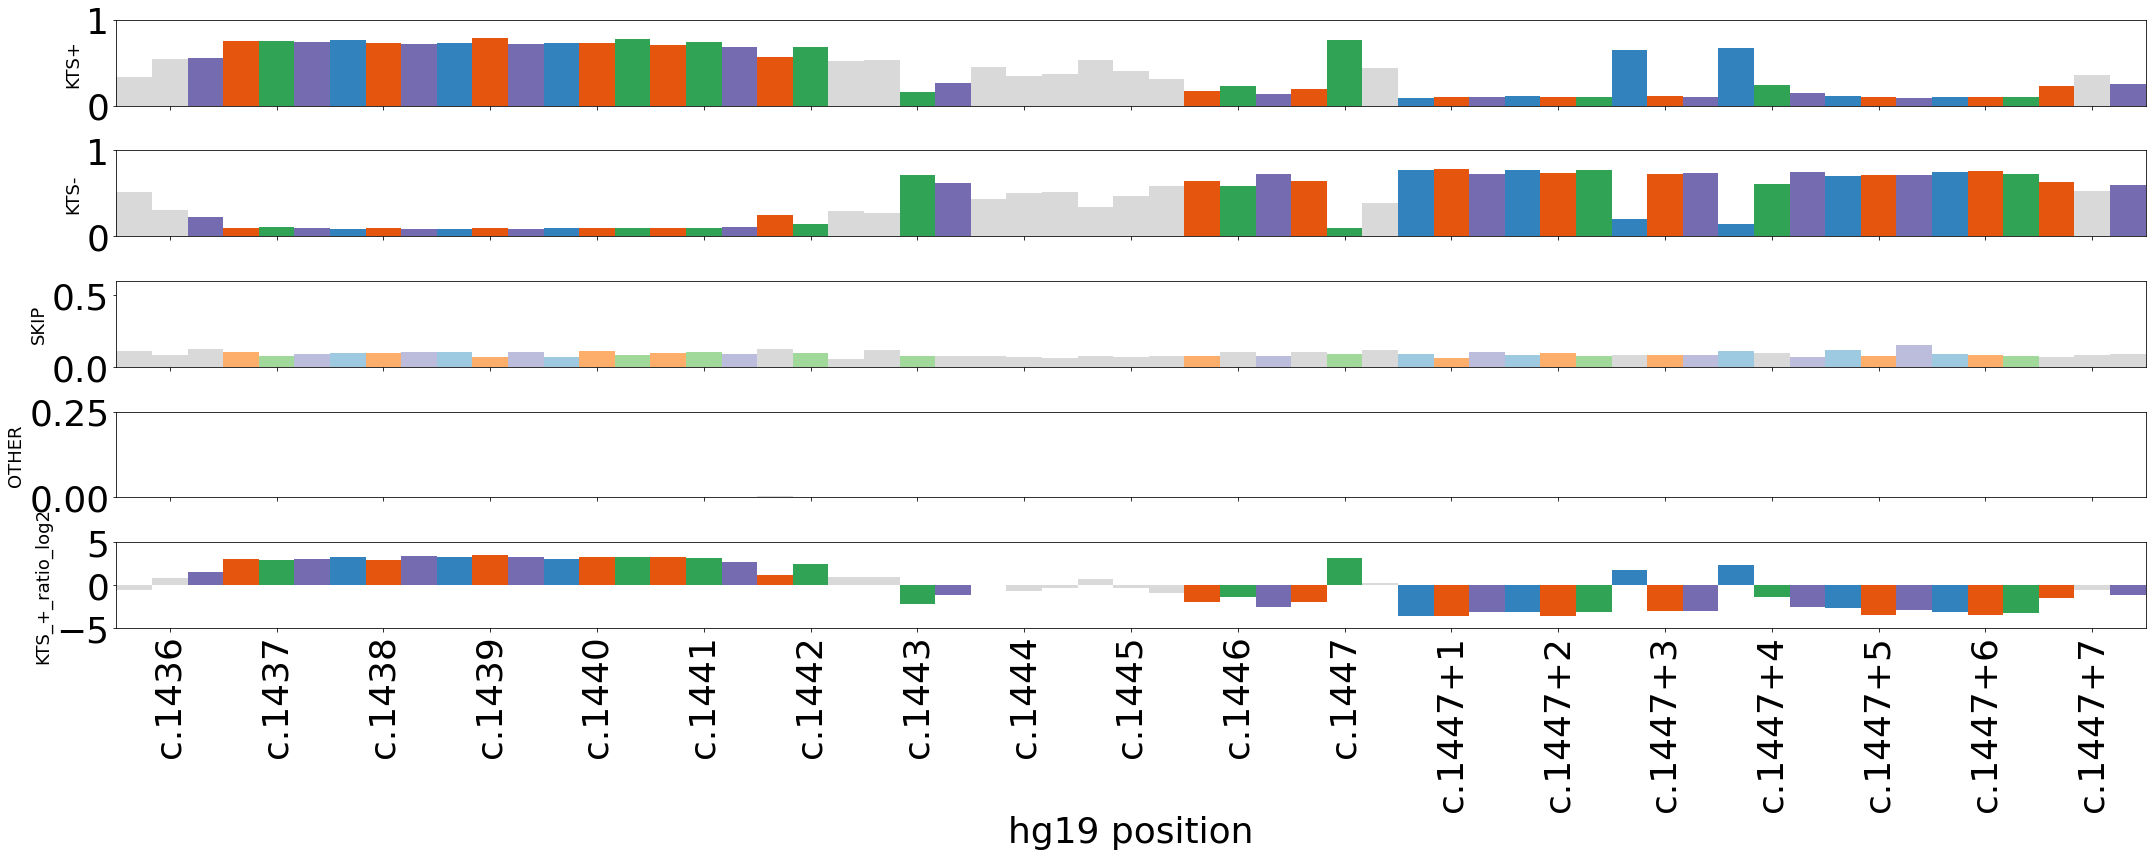

In [92]:
sp.sat_subplots_wrapper( byvartbl_sat.rename( columns = { 'alt': 'a',
                                                          'ref': 'r',
                                                           'alt_c': 'alt',
                                                           'ref_c': 'ref' } ),
                         [ col for col in byvartbl_sat if col.startswith( 'wmean_' ) and '_bs_' not in col ],
                         'hgvs_pos',
                          [ '.85', '.85', '.85', '.85' ],
                          fig_size = ( 30, 12 ),
                          zoom = ( 1348, 1366 ),
                          share_y = False,
                          legend = False,
                          darken_bars = [ ( 'sdv', [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ) ],
                          darken_bars2 = [ ( 'intmed_KTS_+_ratio_log2', [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'intmed_KTS_+_ratio_log2', [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'intmed_SKIP' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'intmed_OTHER' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'intmed_KTS_+_ratio_log2' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ) ],
                          y_ax_lim = [ ( 0, 1 ), ( 0, 1 ), ( 0, .6 ), ( 0, .25 ), ( -5, 5 ) ],
                          y_ax_title = [ col[ 6: ] for col in byvartbl_sat if col.startswith( 'wmean_' ) and '_bs_' not in col ], 
                          x_ax_title = 'hg19 position',
                          tick_spacing = 1,
                          #savefile = '/nfs/kitzman2/smithcat/proj/spliceAI/plots/fas_tracks.pdf'
                     )

In [93]:
view_cols = [ 'pos', 'ref_c', 'alt_c', 'hgvs_pos', 'wmean_KTS+', 'wmean_KTS-', 'wmean_KTS_+_ratio_log2', 'wmean_bs_null_KTS_+_ratio_log2', 'zwmean_bs_null_KTS_+_ratio_log2', 'fc_KTS_+_ratio_log2', ]

byvartbl_wide_m.loc[ ( byvartbl_wide_m.pos >= 1359 ) & ( byvartbl_wide_m.pos <= 1363 ) ][ view_cols ]

,pos,ref_c,alt_c,hgvs_pos,wmean_KTS+,wmean_KTS-,wmean_KTS_+_ratio_log2,wmean_bs_null_KTS_+_ratio_log2,zwmean_bs_null_KTS_+_ratio_log2,fc_KTS_+_ratio_log2
395,1359,A,T,c.1447,0.439645,0.384550,0.245589,0.262134,-0.194973,0.810530
396,1359,A,G,c.1447,0.760930,0.098783,3.118583,0.261243,23.015445,10.664679
397,1359,A,C,c.1447,0.190834,0.649325,-1.929489,0.251387,-16.548751,-6.534097
398,1360,G,T,c.1447+1,0.095431,0.725821,-3.166943,0.246032,-37.432859,-10.203662
399,1360,G,C,c.1447+1,0.101964,0.780630,-3.571535,0.258815,-31.221661,-11.187007
400,1360,G,A,c.1447+1,0.092515,0.777112,-3.642930,0.250311,-43.509102,-11.104639
401,1361,T,G,c.1447+2,0.097303,0.770757,-3.159972,0.260160,-25.852637,-10.383024
402,1361,T,C,c.1447+2,0.105608,0.735516,-3.584586,0.253762,-24.638269,-10.809648
403,1361,T,A,c.1447+2,0.108047,0.777934,-3.153285,0.257831,-25.459460,-10.939153
404,1362,G,T,c.1447+3,0.101979,0.742519,-3.057137,0.245576,-43.597434,-11.411864


In [94]:
byvartbl_wide_m[ 'sdv_sum' ] = byvartbl_wide_m[ [ samp + '_sdv' for samp in byvartbl_long[ 'sample' ].unique() ] ].sum( axis = 1 )

In [95]:
byvartbl_wide_m[ 'intmed_sum' ] = byvartbl_wide_m[ [ samp + '_intmed' for samp in byvartbl_long[ 'sample' ].unique() ] ].sum( axis = 1 )

In [96]:
byvartbl_wide_m[ 'var_seen_sum' ] = sum( [ ( byvartbl_wide_m[ samp + '_n_bc_passfilt' ] > 0 ) & ( byvartbl_wide_m[ samp + '_n_bc_passfilt' ].notnull() ) for samp in byvartbl_long[ 'sample' ].unique() ] )

In [97]:
view_cols = [ 'pos', 'ref_c', 'alt_c', 'hgvs_pos', 'sdv', 'sdv_SKIP', 'sdv_OTHER', 'sdv_KTS_+_ratio_log2', 'sdv_sum', 'intmed_sum', 'var_seen_sum' ]

byvartbl_wide_m.loc[ byvartbl_wide_m.lit_var_path ][ view_cols ]

,pos,ref_c,alt_c,hgvs_pos,sdv,sdv_SKIP,sdv_OTHER,sdv_KTS_+_ratio_log2,sdv_sum,intmed_sum,var_seen_sum
118,1266,G,A,c.1355-1,True,True,True,False,30.0,30.0,32
399,1360,G,C,c.1447+1,True,False,False,True,20.0,20.0,30
400,1360,G,A,c.1447+1,True,False,False,True,26.0,26.0,32
402,1361,T,C,c.1447+2,True,False,False,True,15.0,15.0,31
404,1362,G,T,c.1447+3,True,False,False,True,26.0,26.0,32
406,1362,G,A,c.1447+3,False,False,False,False,0.0,7.0,32
407,1363,C,T,c.1447+4,True,False,False,True,13.0,16.0,32
410,1364,G,T,c.1447+5,True,False,False,True,22.0,22.0,30
412,1364,G,A,c.1447+5,True,False,False,True,18.0,18.0,30
415,1365,T,A,c.1447+6,True,False,False,True,16.0,16.0,31


In [98]:
view_cols = [ 'pos', 'ref_c', 'alt_c', 'hgvs_pos', 'n_bc_passfilt_med', 'wmean_KTS+', 'wmean_KTS-', 'wmean_SKIP', 'wmean_OTHER', 'wmean_KTS_+_ratio_log2', 'zwmean_bs_null_KTS_+_ratio_log2', 'fc_KTS_+_ratio_log2', ]

byvartbl_wide_m.loc[ byvartbl_wide_m.lit_var_path ][ view_cols ]

,pos,ref_c,alt_c,hgvs_pos,n_bc_passfilt_med,wmean_KTS+,wmean_KTS-,wmean_SKIP,wmean_OTHER,wmean_KTS_+_ratio_log2,zwmean_bs_null_KTS_+_ratio_log2,fc_KTS_+_ratio_log2
118,1266,G,A,c.1355-1,56.5,0.072217,0.062558,0.733883,0.097865,0.331703,0.157946,0.916104
399,1360,G,C,c.1447+1,35.5,0.101964,0.780630,0.062608,0.000980,-3.571535,-31.221661,-11.187007
400,1360,G,A,c.1447+1,66.5,0.092515,0.777112,0.090172,0.002039,-3.642930,-43.509102,-11.104639
402,1361,T,C,c.1447+2,23.0,0.105608,0.735516,0.097911,0.000000,-3.584586,-24.638269,-10.809648
404,1362,G,T,c.1447+3,84.5,0.101979,0.742519,0.080798,0.001447,-3.057137,-43.597434,-11.411864
406,1362,G,A,c.1447+3,33.5,0.643376,0.198240,0.085260,0.001896,1.744318,13.772067,6.196320
407,1363,C,T,c.1447+4,33.5,0.142569,0.747727,0.065484,0.000000,-2.539294,-23.671351,-7.516073
410,1364,G,T,c.1447+5,49.5,0.094937,0.713098,0.150828,0.002018,-2.954742,-36.905141,-11.254709
412,1364,G,A,c.1447+5,47.0,0.114138,0.705921,0.115054,0.001790,-2.723120,-30.300358,-8.686316
415,1365,T,A,c.1447+6,31.0,0.102960,0.746363,0.089900,0.001855,-3.106393,-27.768842,-9.935866


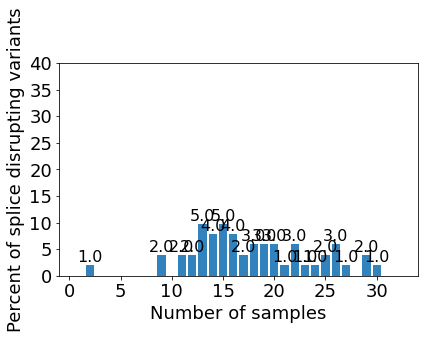

In [99]:
sp.barplot_per_repeat( byvartbl_wide_m.loc[ byvartbl_wide_m[ 'sdv' ] ],
                    'sdv_sum',
                    32,
                    ylim = ( 0, 40 ),
                    ylabel = 'Percent of splice disrupting variants',
                    xlabel = 'Number of samples',
                    #savefig = plot_out + 'sdv_by_samp.pdf',
                    color = light_colors[ 0 ]
                  )

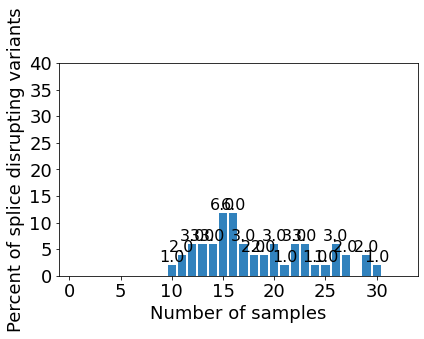

In [100]:
sp.barplot_per_repeat( byvartbl_wide_m.loc[ byvartbl_wide_m[ 'sdv' ] ],
                    'intmed_sum',
                    32,
                    ylim = ( 0, 40 ),
                    ylabel = 'Percent of splice disrupting variants',
                    xlabel = 'Number of samples',
                    #savefig = plot_out + 'sdv_by_samp.pdf',
                    color = light_colors[ 0 ]
                  )

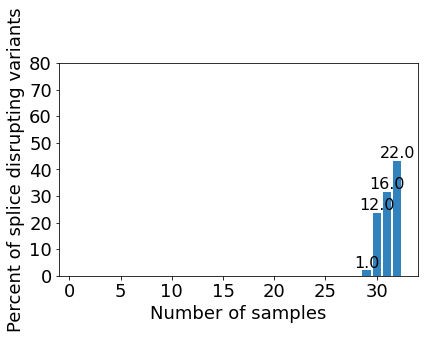

In [101]:
sp.barplot_per_repeat( byvartbl_wide_m.loc[ byvartbl_wide_m[ 'sdv' ] ],
                    'var_seen_sum',
                    32,
                    ylim = ( 0, 80 ),
                    ylabel = 'Percent of splice disrupting variants',
                    xlabel = 'Number of samples',
                    #savefig = plot_out + 'sdv_by_samp.pdf',
                    color = light_colors[ 0 ]
                  )